# Sessie 06: Unsupervised learning

In [1]:
%matplotlib inline
import os
import timeit
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.animation as animation

from PIL import Image
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML

from scipy import stats
from scipy import ndimage

from skimage import data, color, io, filters, morphology,transform, exposure, feature
from skimage.io import imread, imshow

from sklearn.cluster import KMeans, SpectralClustering
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import model_selection
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.metrics import classification_report, silhouette_score
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, roc_curve, auc
from sklearn import linear_model, datasets
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB

##  Clustering

Een supermarkt verzamelde een aantal gegevens van zijn klanten. Deze gegevens wil de supermarkt gebruiken om zijn klanten beter in kaart te brengen. 
Daarvoor wil het clustering toepassen. Op deze manier worden klanten met een gelijkaardig profiel samen gegroepeerd. Dit maakt het mogelijk voor de supermarkt om per cluster van klanten doelgerichter promoties te kunnen aanbieden.

De gegevens kan je vinden in het bestand 'customer.csv'. 

In [80]:
customers = pd.read_csv('Customers.csv')
customers.head()

CustomerID  Gender  Age  Annual_Income  Spending_Score
0           1    Male   19             15              39
1           2    Male   21             15              81
2           3  Female   20             16               6
3           4  Female   23             16              77
4           5  Female   31             17              40

### Analyse van de data
#### Verwijderen van onbelangrijke kolommen
Allereerst wordt de kolom 'CustomerID' geschrapt, zoals hieronder gevraagd.

In [81]:
# Verwijderen van CustomerID
customers.drop('CustomerID', axis=1, inplace=True)
customers.head()


Gender  Age  Annual_Income  Spending_Score
0    Male   19             15              39
1    Male   21             15              81
2  Female   20             16               6
3  Female   23             16              77
4  Female   31             17              40

#### Onderzoek verdeling per geslach
**Opgave**  
Onderzoek de verdeling per geslacht. Wat is de verhouding van mannelijke klanten ten opzichte van vrouwelijke klanten? Gebruik hiervoor de seaborn countplot.

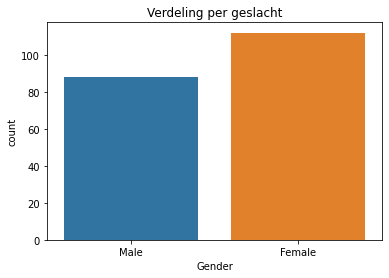

In [82]:
# Verdeling van het geslacht
sns.countplot(x='Gender', data=customers).set_title('Verdeling per geslacht');

In [83]:
customers['Gender'].value_counts(normalize=True)

Female    0.56
Male      0.44
Name: Gender, dtype: float64

**Conclusie in verband met verdeling volgens geslacht**  
De dataset is niet helemaal gebalanceerd volgens geslacht. Er zijn iets meer *mannen* (56%) dan *vrouwen* (44%) in de dataset.

#### Onderzoek naar uitgave volgens geslacht
**Opgave**  
Ga na of vrouwen meer geld lijken te spenderen dan mannen. Visualiseer dit met een boxplot.

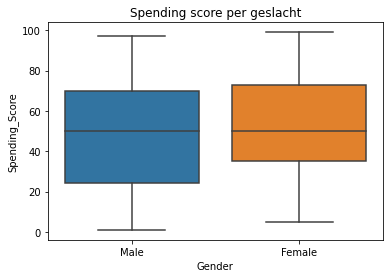

In [84]:
# Boxplot van spending volgens geslacht
sns.boxplot(x='Gender', y='Spending_Score', data=customers).set_title('Spending score per geslacht');

**Conclusie in verband met uitgaven volgens geslacht**  
Over het algemeen is er weinig verschil in uitgaven volgens geslacht. Bij mannen reikt de Q25 en de ondergrens iets lager dan bij vrouwen. De overige waarden liggen bijzonder dicht bij elkaar.

#### Verdeling van leeftijd, inkomen en uitgaven
**opgave**  
Teken de histogrammen van Age, Income en Spending score. Je kan hiervoor de seaborn distplot gebruiken. Zijn deze normaal verdeeld? 

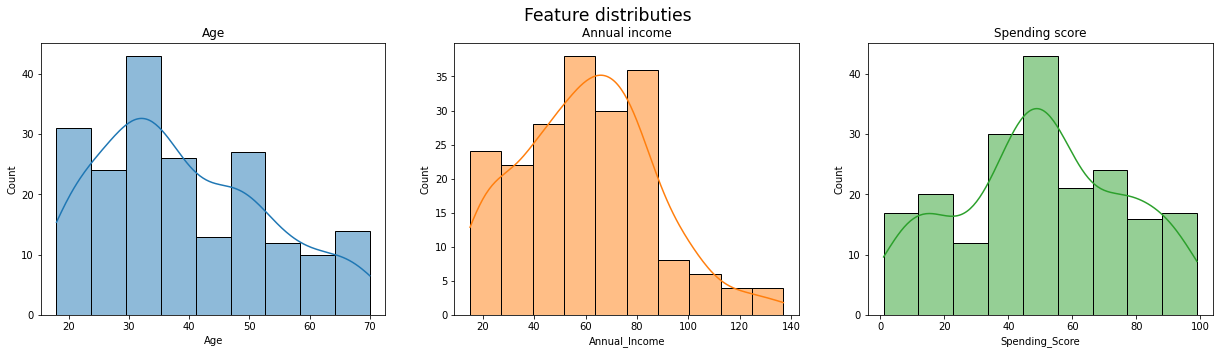

In [85]:
# Distributie van de Age, Income en Spending_Score
fig, axs = plt.subplots(1, 3, figsize=(21,5))
colors = sns.color_palette()
fig.suptitle('Feature distributies', size='xx-large')

sns.histplot(x='Age', data=customers, ax=axs[0], kde=True, color=colors[0]).set_title('Age')
sns.histplot(x='Annual_Income', data=customers, ax=axs[1], kde=True, color=colors[1]).set_title('Annual income')
sns.histplot(x='Spending_Score', data=customers, ax=axs[2], kde=True, color=colors[2]).set_title('Spending score');

**Conclusie in verband met de verdelingen**  
Bovenstaande histogrammen met bijhorende distributieplots laten zien, dat deze features niet normaal verdeeld zijn.

### Clustering

Tijd om op zoek te gaan naar een goede clustering van de klanten. 
Bij clustering is het belangrijk om de features eerst te normaliseren. Veel clustering technieken maken namelijk gebruik van een afstandsfunctie om de gelijkenis tussen verschillende datapunten te bepalen. Daarom is het noodzakelijk dat alle variabelen op een gelijke schaalverdeling staan. 

- Teken een scatterplot tussen Age en Spending_Score. 
- Hoeveel clusters denk je te zien in de scatterplot?
- Schaal de features Age en Spending score
- Pas K-means clutering toe. https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html. Kies een K waarde (=aantal clusters) op basis van je schatting.
- Visualiseer de clusters op de scatterplot
- Ga nu op zoek naar het optimale aantal clusters gebruik makende van de elleboog methode. Hiervoor bereken je de totale gekwadrateerde afstand van de alle datapunten binnen een cluster tot het centrum van de cluster waartoe ze behoren. Dit wordt automatische berekend tijdens het trainen. Je kan deze waarde na training ophalen via de **inertia_** property. Maak een for-loop waarin je K varieert tussen 1 en 10. Voor elke K-waarde train je de K-means en visualiseer je de clusters. Hou ook telkens de inertia_ bij. Maak vervolgens een plot van de 'elleboog-curve' door de inertia_ uit te zetten in functie van K. Daar waar de knik (elleboog) zit is een goede indicatie voor het aantal te kiezen clusters.

Herhaal bovenstaande voor de scatterplot tussen Annual_Income en Spending_Score.


#### Leeftijd en uitgaven
Bovenstaande opgave zal in dezelfde stappen worden uitgewerkt voor de features leeftijd en uitgaven

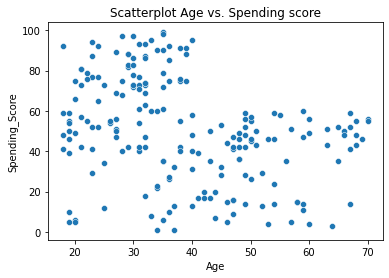

In [86]:
# Clustering Age en Spending_Score
sns.scatterplot(x='Age', y='Spending_Score', data=customers).set_title('Scatterplot Age vs. Spending score');

De scatterplot laat 2 visuele clusters zien. 

In een volgende stap worden deze features gescheiden, geschaald en vervolgens geclusterd tot deze 2 clusters

In [87]:
customers1 = customers[['Age', 'Spending_Score']].copy()
customers1.head()

Age  Spending_Score
0   19              39
1   21              81
2   20               6
3   23              77
4   31              40

In [88]:
mm1 = MinMaxScaler()
customers1ss = pd.DataFrame(mm1.fit_transform(customers1), columns=mm1.get_feature_names_out())
customers1ss.head()

Age  Spending_Score
0  0.019231        0.387755
1  0.057692        0.816327
2  0.038462        0.051020
3  0.096154        0.775510
4  0.250000        0.397959

Array met predicties:
[0 0 1 0 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 0 0 0 1 0 0 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 0 0 1 1 1 1
 1 0 1 1 0 1 1 0 1 1 0 1 1 0 0 1 1 0 1 1 0 0 1 0 1 0 0 1 1 0 1 0 1 1 1 1 1
 0 1 0 0 0 1 1 1 1 0 1 0 0 0 0 1 0 1 0 1 0 0 0 1 0 1 0 1 0 1 0 0 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0]



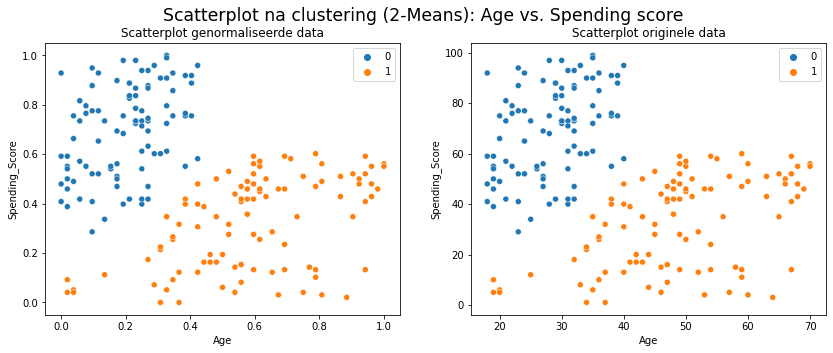

In [89]:
# Init en fit KMeans
k=2
clus1 = KMeans(n_clusters=k, init='random')
clus1.fit(customers1ss)

# Predict cluster
y1 = clus1.predict(customers1ss)
print(f"Array met predicties:\n{y1}\n")

# Scatterplot
fig, axs = plt.subplots(1, 2, figsize=(14,5))
fig.suptitle(f'Scatterplot na clustering ({k}-Means): Age vs. Spending score', size='xx-large')
colorsk = sns.color_palette(n_colors=k)

sns.scatterplot(x='Age', y='Spending_Score', data=customers1ss, hue=y1, palette=colorsk, ax=axs[0]).set_title('Scatterplot genormaliseerde data')
sns.scatterplot(x='Age', y='Spending_Score', data=customers1, hue=y1, palette=colorsk, ax=axs[1]).set_title('Scatterplot originele data');

De visueel waargenomen clusters komen inderdaad sterk overeen met de clustering volgens KMeans

In een volgende stap wordt door middel van de elleboogmethode nagegaan, wat het optimale aantal van clusters is. Omdat de elleboog initieel niet gemakkelijk zichtbaar leek wordt de silhouette plot toegevoegd als een vorm van validatie.

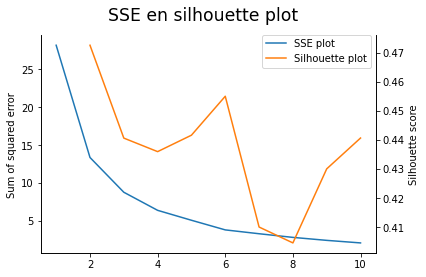

In [90]:
clusters = range(1,11)
sse = []
sil = []

for k in clusters:
    clus1x = KMeans(n_clusters=k)
    clus1x.fit(customers1ss)
    sse.append(clus1x.inertia_)
    if k != 1:
        labels = clus1x.labels_
        sil.append(silhouette_score(customers1ss, labels, metric = 'euclidean'))
        
fig, ax = plt.subplots()
fig.suptitle(f'SSE en silhouette plot', size='xx-large')

sns.lineplot(x=clusters, y=sse, legend=False, label='SSE plot', color=colorsk[0])
sns.despine()
plt.ylabel('Sum of squared error')

ax2 = ax.twinx()
sns.lineplot(x=range(2, len(clusters)+1), y=sil, legend=False, label='Silhouette plot', color=colorsk[1]);
sns.despine(right=False)
plt.ylabel('Silhouette score')
ax.figure.legend(loc='upper right', bbox_to_anchor=(0.90,0.90));


De knik in de elleboogplot lijkt zich te situeren rond een waarde van 2 clusters, maar er lijkt hierna nog een belangrijke winst te halen bij het verder uitbreiden van het aantal clusters. Als validatie toont de silhouetteplot echter dat de silhouettescore inderdaad het hoogst is bij 2 clusters.

#### Inkomen en uitgaven
Bovenstaande opgave zal in dezelfde stappen worden uitgewerkt voor de features inkomen en uitgaven

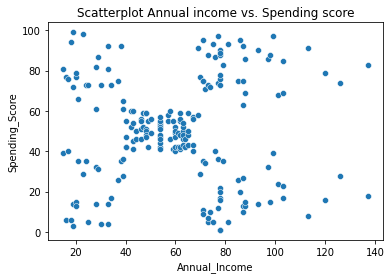

In [91]:
# Clustering Annual_Income en Spending_Score
sns.scatterplot(x='Annual_Income', y='Spending_Score', data=customers).set_title('Scatterplot Annual income vs. Spending score');

De scatterplot laat 5 visuele clusters zien. 

In een volgende stap worden deze features gescheiden, geschaald en vervolgens geclusterd tot deze 5 clusters

In [92]:
customers2 = customers[['Annual_Income', 'Spending_Score']].copy()
customers2.head()

Annual_Income  Spending_Score
0             15              39
1             15              81
2             16               6
3             16              77
4             17              40

In [93]:
mm2 = MinMaxScaler()
customers2ss = pd.DataFrame(mm2.fit_transform(customers2), columns=mm2.get_feature_names_out())
customers2ss.head()

Annual_Income  Spending_Score
0       0.000000        0.387755
1       0.000000        0.816327
2       0.008197        0.051020
3       0.008197        0.775510
4       0.016393        0.397959

Array met predicties:
[1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 1 4 1 0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 2 3 2 4 2 3 2 3 2 4 2 3 2 3 2 3 2 3 2 4 2 3 2 3 2
 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3
 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2]



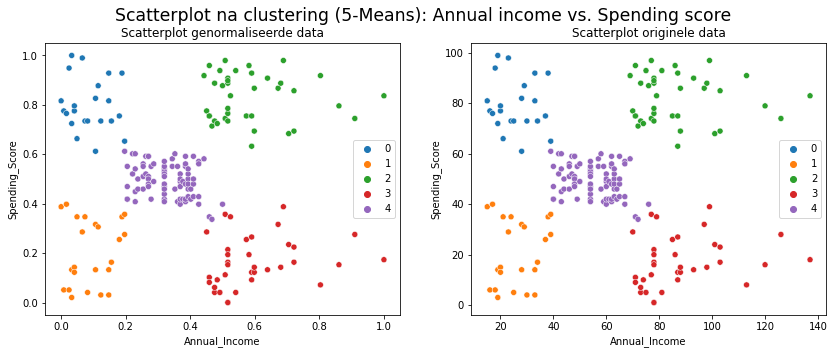

In [94]:
# Init en fit KMeans
k=5
clus2 = KMeans(n_clusters=k, init='random')
clus2.fit(customers2ss)

# Predict cluster
y2 = clus2.predict(customers2ss)
print(f"Array met predicties:\n{y2}\n")

# Scatterplot
fig, axs = plt.subplots(1, 2, figsize=(14,5))
fig.suptitle(f'Scatterplot na clustering ({k}-Means): Annual income vs. Spending score', size='xx-large')
colorsk = sns.color_palette(n_colors=k)

sns.scatterplot(x='Annual_Income', y='Spending_Score', data=customers2ss, hue=y2, palette=colorsk, ax=axs[0]).set_title('Scatterplot genormaliseerde data')
sns.scatterplot(x='Annual_Income', y='Spending_Score', data=customers2, hue=y2, palette=colorsk, ax=axs[1]).set_title('Scatterplot originele data');

De visueel waargenomen clusters komen inderdaad sterk overeen met de clustering volgens KMeans

In een volgende stap wordt door middel van de elleboogmethode nagegaan, wat het optimale aantal van clusters is. Ook nu wordt de silhouette plot toegevoegd als een vorm van validatie.

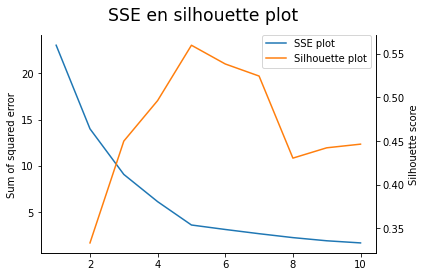

In [95]:
clusters = range(1,11)
sse = []
sil = []

for k in clusters:
    clus2x = KMeans(n_clusters=k)
    clus2x.fit(customers2ss)
    sse.append(clus2x.inertia_)
    if k != 1:
        labels = clus2x.labels_
        sil.append(silhouette_score(customers2ss, labels, metric = 'euclidean'))
        
fig, ax = plt.subplots()
fig.suptitle(f'SSE en silhouette plot', size='xx-large')

sns.lineplot(x=clusters, y=sse, legend=False, label='SSE plot', color=colorsk[0])
sns.despine()
plt.ylabel('Sum of squared error')

ax2 = ax.twinx()
sns.lineplot(x=range(2, len(clusters)+1), y=sil, legend=False, label='Silhouette plot', color=colorsk[1]);
sns.despine(right=False)
plt.ylabel('Silhouette score')
ax.figure.legend(loc='upper right', bbox_to_anchor=(0.90,0.90));


Zoals verwacht bevindt de knik van de elleboogplot ter hoogte van 5 clusters. De silhouette plot bevestigt dit eveneens (hoogste waarde bij 5 clusters)

#### Geslacht en uitgaven
Bovenstaande opgave zal in dezelfde stappen worden uitgewerkt voor de features inkomen en uitgaven

**Bijkomende opgave**  
Probeer nu de scatterplot tussen Gender en Spending_Score te clusteren. Je zal merken dat er affiniteit bestaat tussen de datapunten. Een methode die geschikt is voor het clusteren van deze geconnecteerde data is spectral clustering. Pas deze toe op Annual_Income en Spending_Score
Meer info over SpectralClustering is te vinden op https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html

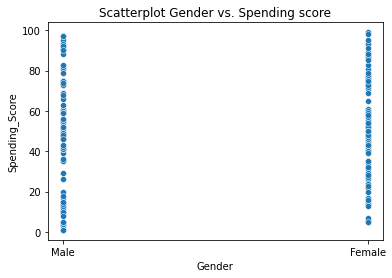

In [96]:
# Clustering Gender en Spending_Score. Eerst via K-means daarna via Spectral Clustering
sns.scatterplot(x='Gender', y='Spending_Score', data=customers).set_title('Scatterplot Gender vs. Spending score');


Er zijn uiteraard 2 duidelijk clusters, namelijk het geslacht zelf. Dit aantal clusters wordt doorgevoerd aan KMeans en SpectralClustering

In [97]:
customers3 = customers[['Gender', 'Spending_Score']].copy()
customers3.replace('Male', 0, inplace=True)
customers3.replace('Female', 1, inplace=True)
customers3.head()

Gender  Spending_Score
0       0              39
1       0              81
2       1               6
3       1              77
4       1              40

In [98]:
mm3 = MinMaxScaler()
customers3ss = pd.DataFrame(mm3.fit_transform(customers3), columns=mm3.get_feature_names_out())
customers3ss.head()

Gender  Spending_Score
0     0.0        0.387755
1     0.0        0.816327
2     1.0        0.051020
3     1.0        0.775510
4     1.0        0.397959

Array met predicties:
[1 1 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 1 1 0 1 1 0 1 0 1 0 1 0 0 1 0 1 1 0 0 0
 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 1 1 1 0 0 1 1 0 0 1 0 1 0 0 0
 1 1 0 1 0 0 1 1 1 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 1 1 0 0 1 1 1 0 0 1 1 1 1
 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 1 1 1 1 1 1 0 0 1 0 0 1 1 0 0 1 0 0 1 1 1 0
 0 1 1 1 0 0 0 0 1 0 1 0 0 0 1 0 1 0 1 0 0 1 1 1 1 1 0 0 1 1 1 1 0 0 1 0 0
 1 0 1 0 0 0 0 1 0 0 0 0 1 1 1]



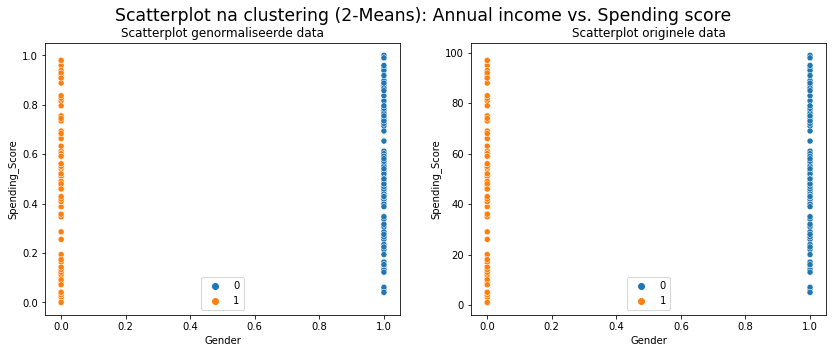

In [99]:
# Init en fit KMeans
k=2
clus3 = KMeans(n_clusters=k, init='random')
clus3.fit(customers3ss)

# Predict cluster
y3 = clus3.predict(customers3ss)
print(f"Array met predicties:\n{y3}\n")

# Scatterplot
fig, axs = plt.subplots(1, 2, figsize=(14,5))
fig.suptitle(f'Scatterplot na clustering ({k}-Means): Annual income vs. Spending score', size='xx-large')
colorsk = sns.color_palette(n_colors=k)

sns.scatterplot(x='Gender', y='Spending_Score', data=customers3ss, hue=y3, palette=colorsk, ax=axs[0]).set_title('Scatterplot genormaliseerde data')
sns.scatterplot(x='Gender', y='Spending_Score', data=customers3, hue=y3, palette=colorsk, ax=axs[1]).set_title('Scatterplot originele data');

KMeans lijkt het prima te doen voor deze dataset en kan de datapunten mooi clusteren in 2 clusters.

Hieronder wordt nagegaan of 2 clusters effectief het beste aantal clusters zijn.

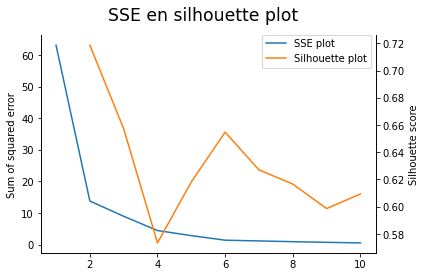

In [100]:
clusters = range(1,11)
sse = []
sil = []

for k in clusters:
    clus3x = KMeans(n_clusters=k)
    clus3x.fit(customers3ss)
    sse.append(clus3x.inertia_)
    if k != 1:
        labels = clus3x.labels_
        sil.append(silhouette_score(customers3ss, labels, metric = 'euclidean'))
        
fig, ax = plt.subplots()
fig.suptitle(f'SSE en silhouette plot', size='xx-large')

sns.lineplot(x=clusters, y=sse, legend=False, label='SSE plot', color=colorsk[0])
sns.despine()
plt.ylabel('Sum of squared error')

ax2 = ax.twinx()
sns.lineplot(x=range(2, len(clusters)+1), y=sil, legend=False, label='Silhouette plot', color=colorsk[1]);
sns.despine(right=False)
plt.ylabel('Silhouette score')
ax.figure.legend(loc='upper right', bbox_to_anchor=(0.90,0.90));


De knik van de elleboogplot bevindt zich inderdaad bij 2 clusters. Ook hier bevestigt de silhouetteplot deze bevindingen.

Zoals opgegeven wordt nu SpectralClustering uitgevoerd.

Array met predicties:
[1 1 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 1 1 0 1 1 0 1 0 1 0 1 0 0 1 0 1 1 0 0 0
 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 1 1 1 0 0 1 1 0 0 1 0 1 0 0 0
 1 1 0 1 0 0 1 1 1 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 1 1 0 0 1 1 1 0 0 1 1 1 1
 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 1 1 1 1 1 1 0 0 1 0 0 1 1 0 0 1 0 0 1 1 1 0
 0 1 1 1 0 0 0 0 1 0 1 0 0 0 1 0 1 0 1 0 0 1 1 1 1 1 0 0 1 1 1 1 0 0 1 0 0
 1 0 1 0 0 0 0 1 0 0 0 0 1 1 1]



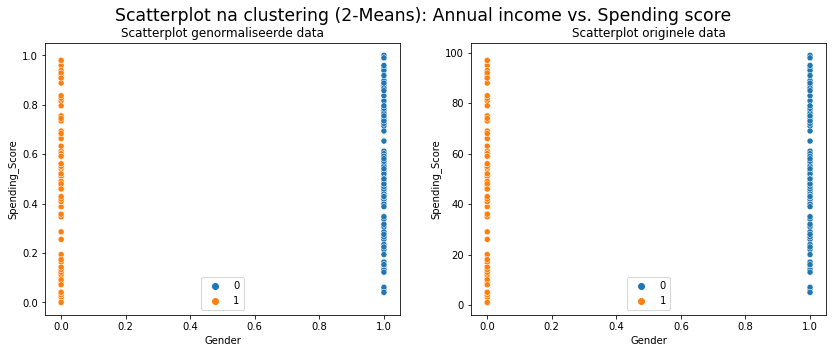

In [101]:
# Init en fit en predict Spectral Clustering
k=2
clus3b = SpectralClustering(n_clusters=k)
y3b = clus3b.fit_predict(customers3ss)

print(f"Array met predicties:\n{y3b}\n")

# Scatterplot
fig, axs = plt.subplots(1, 2, figsize=(14,5))
fig.suptitle(f'Scatterplot na clustering ({k}-Means): Annual income vs. Spending score', size='xx-large')
colorsk = sns.color_palette(n_colors=k)

sns.scatterplot(x='Gender', y='Spending_Score', data=customers3ss, hue=y3b, palette=colorsk, ax=axs[0]).set_title('Scatterplot genormaliseerde data')
sns.scatterplot(x='Gender', y='Spending_Score', data=customers3, hue=y3b, palette=colorsk, ax=axs[1]).set_title('Scatterplot originele data');

Het resultaat is gelijkaardig aan dat van KMeans

#### Leeftijd, inkomen en uitgaven
**Opgaven**  
Zoek de clusters via K-means op basis van Age, Annual_Income en Spending_Score. Gebruik ook hier de elleboog methode om het aantal clusters te bepalen. Zet na clustering de data opniew terug naar de oorspronkelijk schaal. De meeste scalers beschikken over een inverse_transform methode die je kan gebruiken om terug te schalen. Plot de scatterplot en de clusters in 3D. Je bent vrij in de keuze van de library die je hiervoor gebruikt. In hoeveel clusters heb je de data ingedeeld? Kan je ze beschrijven? Welke zijn interessant voor de supermarkt om op te focussen willen ze hun winst verhogen?

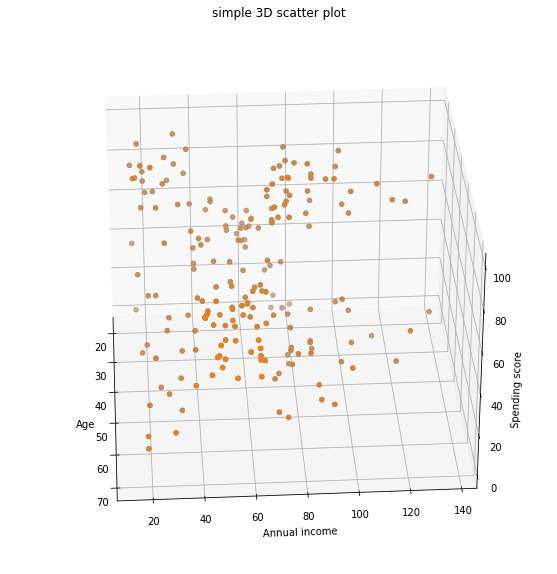

In [102]:
# Clustering van Age, Annual_Income en Spending_Score + 3D visualisatie en uiteindelijke interpretatie
z = customers['Spending_Score']
x = customers['Age']
y = customers['Annual_Income']
 
# Creating figure
fig = plt.figure(figsize = (15, 10))
ax = plt.axes(projection ="3d")
 
# Creating plot
def init():
    ax.scatter3D(x, y, z)
    ax.set_xlabel('Age')
    ax.set_ylabel('Annual income')
    ax.set_zlabel('Spending score')
    plt.title("simple 3D scatter plot")
    return fig,

def animate(i):
    ax.view_init(elev=30., azim=3.6*i)
    return fig,

# Animate
ani = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=100, blit=True)    

HTML(ani.to_html5_video())


Op basis van de 3D scatterplot lijken er zich 6 clusters te vormen. Dit zal hieronder verder worden uitgezocht na schalen.

In [103]:
customers4 = customers[['Age', 'Annual_Income', 'Spending_Score']].copy()
customers4.head()

Age  Annual_Income  Spending_Score
0   19             15              39
1   21             15              81
2   20             16               6
3   23             16              77
4   31             17              40

In [104]:
mm4 = MinMaxScaler()
customers4ss = pd.DataFrame(mm4.fit_transform(customers4), columns=mm4.get_feature_names_out())
customers4ss.head()

Age  Annual_Income  Spending_Score
0  0.019231       0.000000        0.387755
1  0.057692       0.000000        0.816327
2  0.038462       0.008197        0.051020
3  0.096154       0.008197        0.775510
4  0.250000       0.016393        0.397959

Array met predicties:
[0 5 0 5 0 5 1 5 1 5 1 5 1 5 1 5 1 5 1 5 1 5 1 5 1 5 1 5 1 5 1 5 1 5 1 5 1
 5 1 5 4 5 1 5 1 5 4 0 0 0 4 0 0 4 4 4 4 4 0 4 4 0 4 4 4 0 4 4 0 0 4 4 4 4
 4 0 4 0 0 4 4 0 4 4 0 4 4 0 0 4 4 0 4 0 0 0 4 0 4 0 0 4 4 0 4 0 4 4 4 4 4
 0 0 0 0 0 4 4 4 4 0 0 2 2 0 2 3 2 3 2 3 2 0 2 0 2 3 2 0 2 3 2 0 2 0 2 3 2
 3 2 3 2 3 2 3 2 3 2 3 2 4 2 0 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3
 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2]



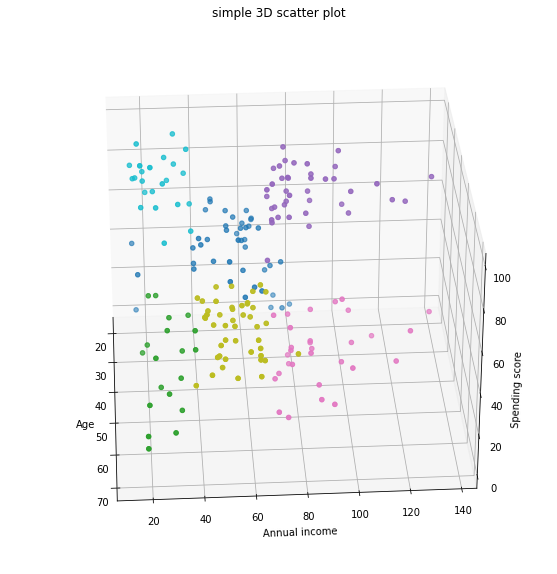

In [105]:
# Init en fit KMeans
k=6
clus4 = KMeans(n_clusters=k, init='random')
clus4.fit(customers4ss)

# Predict cluster
y4 = clus4.predict(customers4ss)
print(f"Array met predicties:\n{y4}\n")



z = customers4['Spending_Score']
x = customers4['Age']
y = customers4['Annual_Income']
 
# Creating figure
fig = plt.figure(figsize = (15, 10))
ax = plt.axes(projection ="3d")
 
# Creating plot
def init():
    ax.scatter3D(x, y, z, c=y4, cmap='tab10')
    ax.set_xlabel('Age')
    ax.set_ylabel('Annual income')
    ax.set_zlabel('Spending score')
    plt.title("simple 3D scatter plot")
    return fig,

def animate(i):
    ax.view_init(elev=30., azim=3.6*i)
    return fig,

# Animate
ani = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=100, blit=True)    

HTML(ani.to_html5_video())

Het resultaat met 6 clusters lijkt min of meer visueel te kloppen, maar door de complexiteit van 3D op 2D schermen, wordt de voorkeur gegeven aan de elleboogplot en de silhouette plot. Deze worden hieronder uitgewerkt.

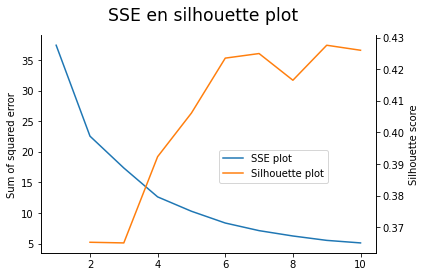

In [106]:
clusters = range(1,11)
sse = []
sil = []

for k in clusters:
    clus4x = KMeans(n_clusters=k)
    clus4x.fit(customers4ss)
    sse.append(clus4x.inertia_)
    if k != 1:
        labels = clus4x.labels_
        sil.append(silhouette_score(customers4ss, labels, metric = 'euclidean'))
        
fig, ax = plt.subplots()
fig.suptitle(f'SSE en silhouette plot', size='xx-large')

sns.lineplot(x=clusters, y=sse, legend=False, label='SSE plot', color=colorsk[0])
sns.despine()
plt.ylabel('Sum of squared error')

ax2 = ax.twinx()
sns.lineplot(x=range(2, len(clusters)+1), y=sil, legend=False, label='Silhouette plot', color=colorsk[1]);
sns.despine(right=False)
plt.ylabel('Silhouette score')
ax.figure.legend(loc='upper right', bbox_to_anchor=(0.80,0.5));


De knik in de elleboogplot is niet mooi zichtbaar, maar lijkt zich te situeren rond 6 clusters. Hier is de silhouetteplot ook het hoogst. Een belangrijke opmerking hieromtrent is dat deze plot wijzigt bij elke uitwerking ten gevolge van randomisatie

##  Face recognition
**Opgave**  
Het doel van deze opdracht bestaat erin om een zo performant mogelijke gezichtsherkenning uit te voeren aan de hand van Eigenfaces. Deze techniek van Eigenfaces was een van de eerste succesvolle pogingen om via computer vision gezichten te classificeren. Tegenwoordig is deze methode achterhaald en mijlenver voorbij gestoken door technieken gebaseerd op Convolutional Neural Networks (zie module deep learning).
Bij deze opdracht worden een training- en test set van gezichten meegeleverd. De gezichten zijn afkomstig uit de Georgia Tech face database (http://www.anefian.com/research/face_reco.htm) en bevatten gezichten van 50 verschillende personen. Van elke persoon werden 15 foto's genomen.
De foto's die ter beschikken worden gesteld ondergingen al enige vorm van preprocessing zoals face cropping en face rotation.
Uit de bestandsnaam van elke foto kan het persoons ID worden gehaald. Voorbeeld: person22\_15\.jpg. Hier gaat het om de 15de foto van persoon 22.

Deze opdracht is in heel sterke mate gelijklopend met de demo MNIST_PCA.

De stappen om tot een succesvolle realisatie te komen zijn als volgt:
- Inlezen van de afbeeldingen. Haal het label van het gezicht uit de bestandsnaam.
- Converteer de afbeeldingen naar grijswaarden. Dit wordt reeds gedaan in de beschikbare code tijdens het inlezen van de afbeeldingen. 
- Schaal alle afbeeldingen naar dezelfde afmeting. Bijvoorbeeld 150x110 (150 rijen, 110 kolommen). Dit kan via skimage.transform.resize().
- Transformeer de training en test set zodanig dat een individuele afbeelding bestaat uit 1 rij. Met andere woorden maak van een 2D afbeelding een 1D vector door alle rijen van de afbeelding achter elkaar te plakken. Dit kan via np.reshape().
- Doe Principle Component Analyse. In de praktijk gebruikt men doorgaans een 40-tal Eigenfaces. Dit is ook het aantal wat je in eerste instantie mag gebruiken. Later wordt gevraagd dit aantal te variëren.
- Train een classifier (logistic regression, SVM, Random Forest Classifier) op de principle components.
- Test de classifier en evalueer de performantie (accuracy, recall, precision). Argumenteer waarom je voor een bepaalde classifier zou kiezen. 
- Doe hyperparameter tuning en probeer verschillende aantallen Eigenfaces.


Als uitbreiding wordt gevraagd om een face detector te bouwen. In tegenstelling tot gezichtsherkenning is het niet de bedoeling het gezicht in de afbeelding te classificeren maar om de locatie van het gezicht in de afbeelding via een bounding box te kunnen aanduiden.

### Bepalen van de principle components
#### Inlezen en tonen van images
In eerste instantie worden de images ingeladen, de labels worden geëxtraheerd uit de bestandsnaam. Hiervoor wordt gebruik gemaakt van het meegeleverde script. Hier worden geen wijzingen aangebracht.

In [23]:
# Inlezen van de training images
training_images = [] # empty list
test_images = [] # empty list
y_train = [] # empty list
y_test = [] # empty list

path = "./Faces/Training_images/"
valid_images = [".jpg",".gif",".png"]

for f in os.listdir(path):
    ext = os.path.splitext(f)[1]
    if ext.lower() not in valid_images:
        continue
    training_images.append(imread(os.path.join(path,f),as_gray=True))
    y_train.append(int(f[6:8]))
   
     
# Inlezen van de test images
path = "./Faces/Test_images/"
valid_images = [".jpg",".gif",".png"]
for f in os.listdir(path):
    ext = os.path.splitext(f)[1]
    if ext.lower() not in valid_images:
        continue
    test_images.append(imread(os.path.join(path,f),as_gray=True))
    y_test.append(int(f[6:8]))
    
print("aantal training images: ", len(y_train))
print("aantal test images: ", len(y_test))

print("aantal unieke personen in de training set: ", len(set(y_train)))
print("aantal unieke personen in de test set: ", len(set(y_test)))

aantal training images:  500
aantal test images:  250
aantal unieke personen in de training set:  50
aantal unieke personen in de test set:  50


Label van de index: 2


(-0.5, 129.5, 168.5, -0.5)

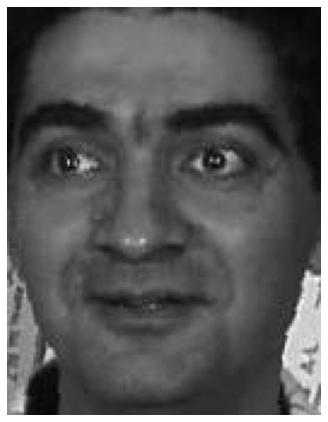

In [24]:
# Tonen van een afbeelding ter controle via plt.imshow(image,cmap='gray')
image_index = 9
print(f'Label van de index: {y_train[image_index]}')

plt.rcParams["figure.figsize"] = (6.5,7.5)
plt.imshow(training_images[image_index],cmap = 'gray')
plt.axis('off')


#### Herschalen van de images
De images worden herschaald tot afbeeldingen van 150x110 pixels zoals opgegeven.

In het eerste codeblok wordt dit uitgevoerd op 1 image. Vervolgens wordt dit toegepast op de hele dataset.

In [25]:
# Afbeelding herschalen naar afbeeldingen van 150 rijen en 110 kolommen
# Skimage transform bevat de methode transform
# transform.resize(image,(rows,cols),mode='constant')
new_image = transform.resize(training_images[image_index], (150,110), mode='constant')
print(f'{new_image}\n')
print(f'De dimensies van de getransformeerde afbeelding: {new_image.shape[0]} x {new_image.shape[1]}')


[[0.07060663 0.06832762 0.06366784 ... 0.05114727 0.05169268 0.05122876]
 [0.07195111 0.06876097 0.06148367 ... 0.05074086 0.05416089 0.05490196]
 [0.06977434 0.06736905 0.06092275 ... 0.04900824 0.05239143 0.05366013]
 ...
 [0.48387792 0.5543803  0.6236207  ... 0.44460301 0.48971251 0.67033243]
 [0.47064248 0.53064497 0.56996957 ... 0.49976009 0.50633635 0.65253075]
 [0.46489422 0.46456773 0.45871462 ... 0.47768952 0.50066025 0.51695236]]

De dimensies van de getransformeerde afbeelding: 150 x 110


In [26]:
trainset = [transform.resize(image, (150,110), mode='constant') for image in training_images]
testset = [transform.resize(image, (150,110), mode='constant') for image in test_images]


#### Training en test set
Vanuit de herschaalde afbeeldingen worden de uiteindelije training en test sets gemaakt. Bij het aanmaken van deze sets wordt een lege 3de dimensie gemaakt. Daarom worden de sets herschapen tot een array met aantal rijen afkomstig uit de origine sets en evenveel kolommen als er pixels zijn. Hierdoor is de dataset onmiddellijk klaar voor PCA analyse.

In [27]:
# Omzetten naar training en test set. Afbeeldingen naar 1 dimensie brengen (1 rij pixels per afbeelding)
X_train = np.array([image.reshape(1,-1).tolist() for image in trainset]).reshape(len(trainset),150*110)
X_test = np.array([image.reshape(1,-1).tolist() for image in testset]).reshape(len(testset),150*110)

#### Dimensionaliteitsreductie met principle component analyse
Zoals opgegeven worden de sets gereduceerd tot 40 features. Hierna worden de 10 eerste principle components gevisualiseerd en de scores van de principle components weergegeven

In [28]:
# Dimensionality reduction: Principle Component Analysis met 40 componenten
n = 40

#Train het PCA algoritme op de training data
pca_model = PCA(n_components=n, svd_solver='full')
pca_model.fit(X_train)

#Reduceer het aantal dimensies van zowel de trainig set als de test set
X_train_pca = pca_model.transform(X_train)
X_test_pca = pca_model.transform(X_test)

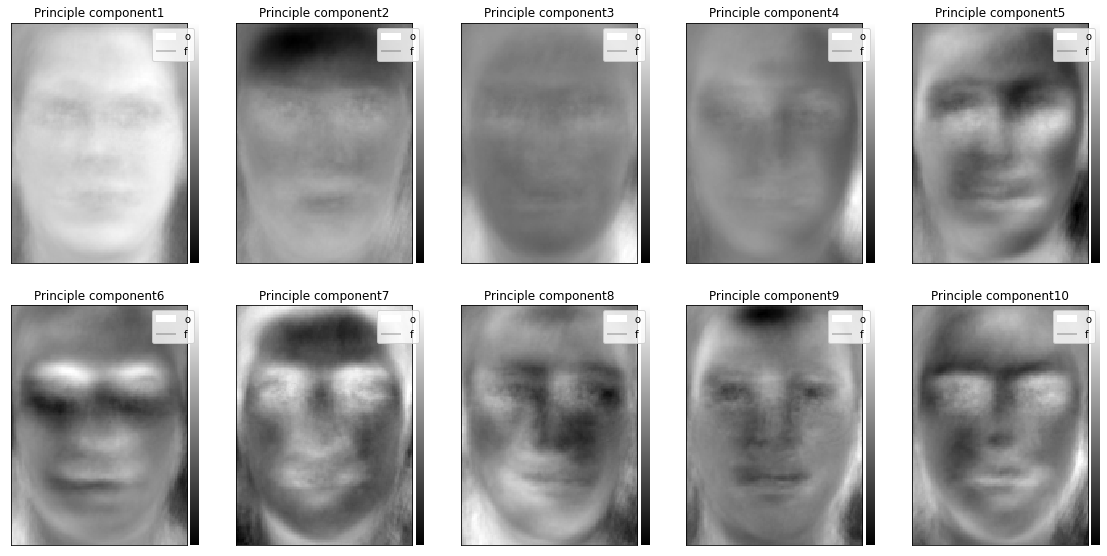

In [29]:
# Visualiseer de eerste 10 principle components (de 10 eerste Eigenfaces)
PCA_components = pca_model.components_

fig = plt.figure(figsize=(16, 9)) 
for i in range(0,10):
    ax = fig.add_subplot(2, 5, i+1)
    imshow(PCA_components[i].reshape((150,110)),cmap='gray')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    plt.axis('off')
    plt.legend('off')
    
    ax.set_title('Principle component'+str(i+1))
    # x and y axis should be equal length
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
plt.show()

In [30]:
# Geef de PCA scores van een bepaald gezicht
# Wat is de betekenis van deze scores?
print(X_train_pca[image_index,:])


[-14.15927696  -2.79796682   3.9814388    4.38484433  -0.21369561
  -1.16612284  -2.92063227   0.12510455  -1.97153733   3.33934381
  -1.69441215  -1.97566444  -0.03230351   1.89573755  -0.86316372
   1.13667975  -0.92742131  -1.52487497   0.31419352  -0.41186141
   0.48419215  -2.44279949   0.40436639  -0.46226429  -0.63795604
  -1.15952607  -0.41817807   1.43257255   0.22026632  -0.03135896
   0.28570611   1.01298297  -0.96150686  -0.80585945   1.06723201
   0.05468409   0.31056836   0.42100331   0.24168309   0.4108551 ]


#### Verklaring van de variantie na PCA
Hieronder wordt onderzocht hoeveel variantie de individuele principle components verklaren in het model. Daaronder wordt de totale variantie verklaard. Als laatste worden deze resultaten ook visueel voorgesteld.

In [31]:
# Geef weer hoeveel procent van de variantie in totaal wordt verklaard door alle principle components
print(f'Verklaring van de variantie per principle component: \n{pca_model.explained_variance_ratio_}\n')
print(f'Totale verklaring van de variantie door het model: {np.sum(pca_model.explained_variance_ratio_)}')

Verklaring van de variantie per principle component: 
[0.31299019 0.08180821 0.05522093 0.04549319 0.03536998 0.02913374
 0.02526075 0.02224305 0.01600152 0.01554571 0.01351107 0.01220864
 0.01038052 0.01000331 0.0087922  0.00781917 0.00724352 0.00672377
 0.00597678 0.0057304  0.00558901 0.00542261 0.00512601 0.00494481
 0.00482883 0.00462944 0.00453047 0.00431564 0.00423441 0.00382722
 0.00378696 0.00368965 0.0034914  0.00334989 0.00315999 0.00307202
 0.00299498 0.00290249 0.0027832  0.00268607]

Totale verklaring van de variantie door het model: 0.8068217477820615


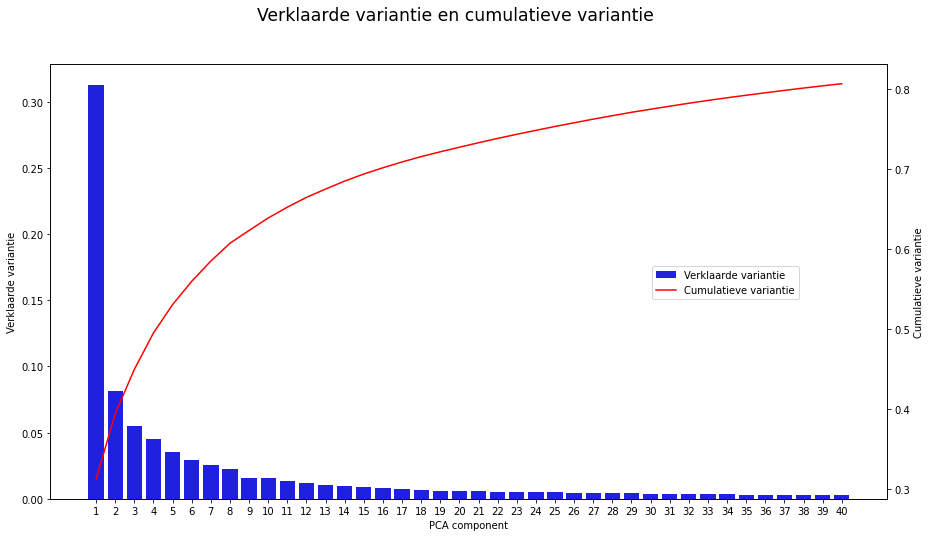

In [32]:
# Genereer een gecombineerde grafiek van de verklaarde variantie in functie van de principle component. 
# Staafdiagram van de verklaarde variantie van de individuele principle componenten en anderzijds de cumulatieve
# verklaarde variantie
PCAnumber = np.arange(1,n+1)
PCA_explained_cumulative = np.cumsum(pca_model.explained_variance_ratio_)

fig = plt.figure(figsize=(15, 8)) 
fig.suptitle('Verklaarde variantie en cumulatieve variantie', size='xx-large')

ax = sns.barplot(x=PCAnumber, y=pca_model.explained_variance_ratio_, color='blue', label='Verklaarde variantie')
plt.xlabel('PCA component')
plt.ylabel('Verklaarde variantie')
ax2=ax.twinx() # dubbele y-as
ax.yaxis.set_label_position('left')
ax2.yaxis.set_label_position('right')
ax2.set_ylabel('Cumulatieve variantie')
plt.plot(PCA_explained_cumulative, c='red', label='Cumulatieve variantie')
ax.figure.legend(loc='center', bbox_to_anchor=(0.75, 0.5));

#### Reconstructie van een afbeelding aan de hand van Eigenfaces
Hieronder volgt het proces om een van de afbeeldingen te reconstrueren op basis van de principle components. Dezelfde afbeelding als hierboven wordt gebruikt.

(16500,)


(-0.5, 109.5, 149.5, -0.5)

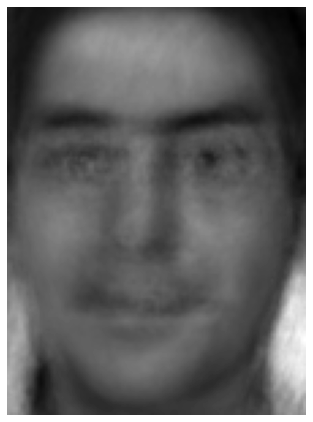

In [33]:
# Reconstrueer een gezicht aan de hand van de Eigenfaces
image_reconstructed = pca_model.inverse_transform(X_train_pca[image_index,:])
print(image_reconstructed.shape)

plt.imshow(image_reconstructed.reshape((150,110)),cmap = 'gray')
plt.axis('off')

### Classificatie
**Opgave**  
Train meerdere classifiers (logistic regression, SVM, Random Forest Trees, Ensembles) voor het herkennen van de gezichten. Gebruik als features de gewichtsfactoren bekomen via de PCA analyse. Doe cross-validation voor het vinden van de optimale hyperparameters.

- Varieer eens het aantal gebruikte Eigenfaces. Wat gebeurt er met de accuracy van de classifiers wanneer je het aantal vermindert (minder dan 40) en wat als je ze vermeerdert.
- Heeft het aantal gebruikte Eigenfaces een sterke invloed op de rekentijd?
- Beschrijf duidelijk welke methode je verkiest.
- Visualiseer een aantal verkeerd geclassificeerde gezichten. 

In [34]:
# Scaling van de eigenfaces
ss = StandardScaler()
X_train_pca = ss.fit_transform(X_train_pca)
X_test_pca = ss.transform(X_test_pca)

In [35]:
# Classificatie
# Initialisatie van de modellen
clf1 = LogisticRegression(max_iter=100000, class_weight='balanced')
clf2 = SVC(max_iter=100000000, class_weight='balanced')
clf3 = RandomForestClassifier()

In [36]:
# Initialisatie van de grids
grid1 = {"C": np.logspace(-2,3,10), 
         "solver": ["lbfgs", "sag"]}

grid2 = [
    {
        'kernel': ['linear'],
        'C': np.logspace(-3,3,11)},
    {
        'kernel': ['rbf'], 
        'C': np.linspace(0.01,20,10), 
        'gamma': [0.0001, 0.001, 0.01, 0.1, 0.2]},
    {
        'kernel': ['poly'],
        'C': np.linspace(0.01,20,10)}
]

grid3 = {"n_estimators": range(1, 1001, 250),
         "class_weight": ['balanced', 'balanced_subsample'],
         "max_depth": [None, 5, 10, 20],
         "min_samples_split": [2, 5, 10],
         "min_samples_leaf": [2, 5, 10],
         "max_features": ['auto', 'sqrt', 'log2']}
 

#### Logistische regressie
Eerst wordt een logistische regressie model getraind. Hyperparametertuning en cross validation gebeurt door middel van GridSearch

Fitting 8 folds for each of 20 candidates, totalling 160 fits
Beste parameters:	{'C': 77.42636826811278, 'solver': 'lbfgs'}
Beste score: 	0.874167946748592
Confusion matrix


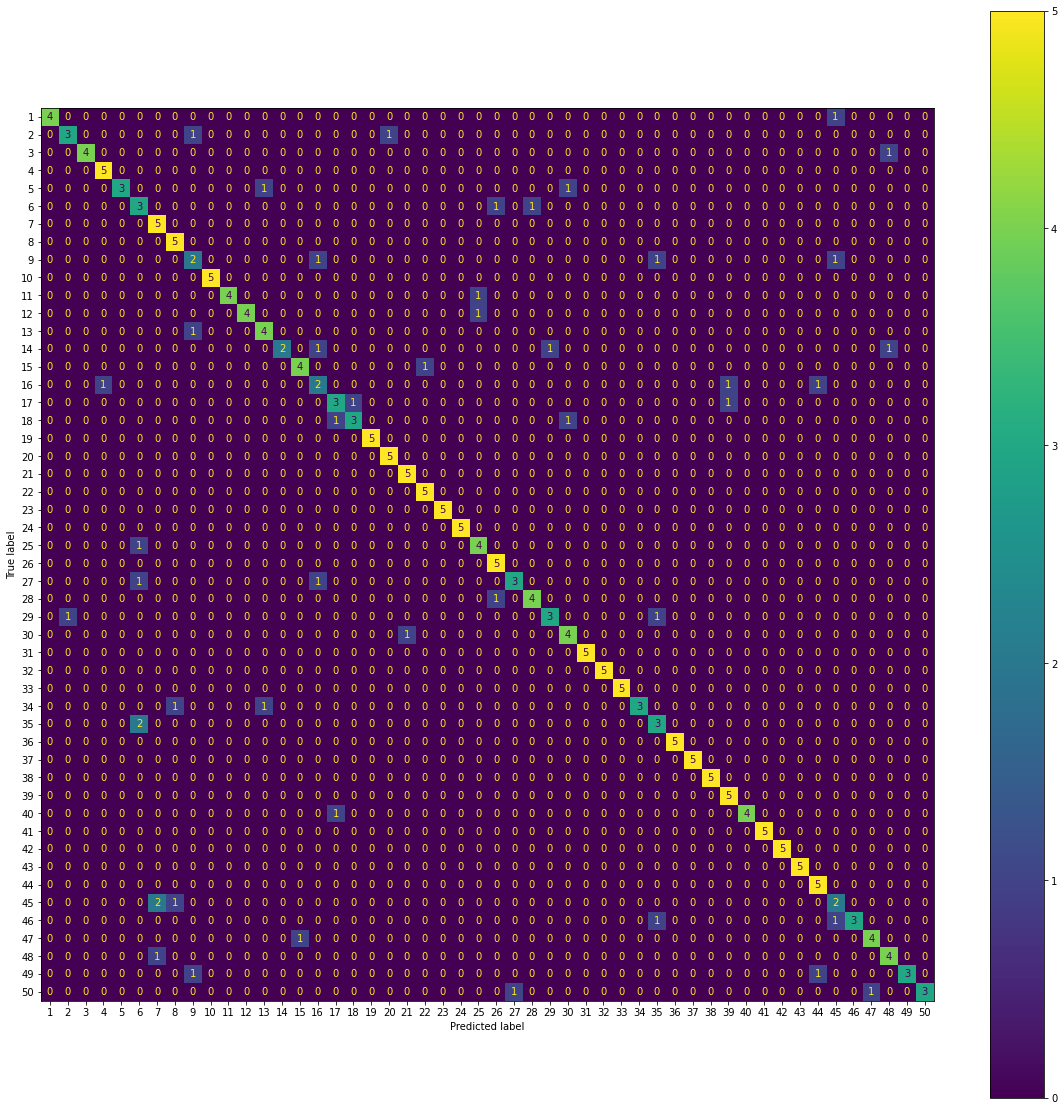

              precision    recall  f1-score   support

           1       1.00      0.80      0.89         5
           2       0.75      0.60      0.67         5
           3       1.00      0.80      0.89         5
           4       0.83      1.00      0.91         5
           5       1.00      0.60      0.75         5
           6       0.43      0.60      0.50         5
           7       0.62      1.00      0.77         5
           8       0.71      1.00      0.83         5
           9       0.40      0.40      0.40         5
          10       1.00      1.00      1.00         5
          11       1.00      0.80      0.89         5
          12       1.00      0.80      0.89         5
          13       0.67      0.80      0.73         5
          14       1.00      0.40      0.57         5
          15       0.80      0.80      0.80         5
          16       0.40      0.40      0.40         5
          17       0.60      0.60      0.60         5
          18       0.75    

In [53]:
# Logistic regression
start_clf1 = timeit.default_timer()

gs1 = GridSearchCV(clf1, grid1, cv=8, n_jobs=-1, scoring='accuracy', verbose=1)
gs1.fit(X_train_pca, y_train)

stop_clf1 = timeit.default_timer()
diff_clf1 = stop_clf1 - start_clf1
diff_fit_clf1 = diff_clf1 / (len(ParameterGrid(grid1)) * 8)

# Beste parameters en score
print(f"Beste parameters:\t{gs1.best_params_}")
print(f"Beste score: \t{gs1.best_score_}")

# Confusion matrix
print("Confusion matrix")
logr_pred = (gs1.predict(X_test_pca))
plt.rcParams["figure.figsize"] = (20,20)
ConfusionMatrixDisplay.from_predictions(y_test, logr_pred)
plt.show()

# Classification report
print(classification_report(y_test, logr_pred))

Het beste logistische regressie model kent een accuracy van 81%. De confusionmatrix laat zien dat voor enkele gezichten, het model moeilijkheden heeft om juist te classificeren.

In de volgende stap worden verschillende aantallen van principle components getest. De resultaten worden onder elkaar weergegeven. De belangrijkste gegevens worden opgeslagen in een lijst. Na het onderzoeken van support vector machines zal deze lijst worden omgezet tot een DataFrame voor bijkomende analyse.

LOGISTISCHE REGRESSIE MET 10 PRINCIPLE COMPONENTS
Fitting 8 folds for each of 20 candidates, totalling 160 fits
Beste parameters:	{'C': 77.42636826811278, 'solver': 'lbfgs'}
Beste score: 	0.8003072196620583
Confusion matrix


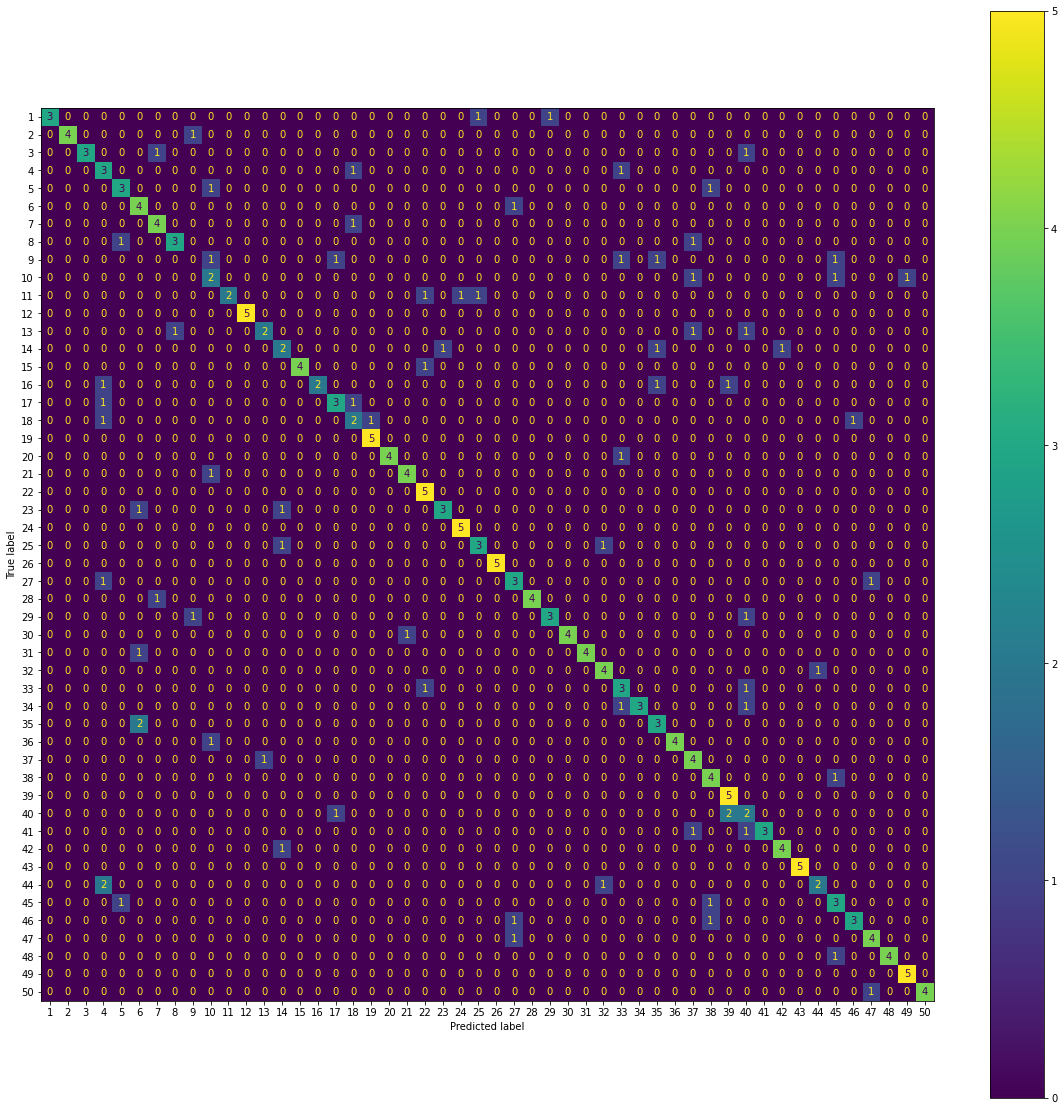

              precision    recall  f1-score   support

           1       1.00      0.60      0.75         5
           2       1.00      0.80      0.89         5
           3       1.00      0.60      0.75         5
           4       0.33      0.60      0.43         5
           5       0.60      0.60      0.60         5
           6       0.50      0.80      0.62         5
           7       0.67      0.80      0.73         5
           8       0.75      0.60      0.67         5
           9       0.00      0.00      0.00         5
          10       0.33      0.40      0.36         5
          11       1.00      0.40      0.57         5
          12       1.00      1.00      1.00         5
          13       0.67      0.40      0.50         5
          14       0.40      0.40      0.40         5
          15       1.00      0.80      0.89         5
          16       1.00      0.40      0.57         5
          17       0.60      0.60      0.60         5
          18       0.40    

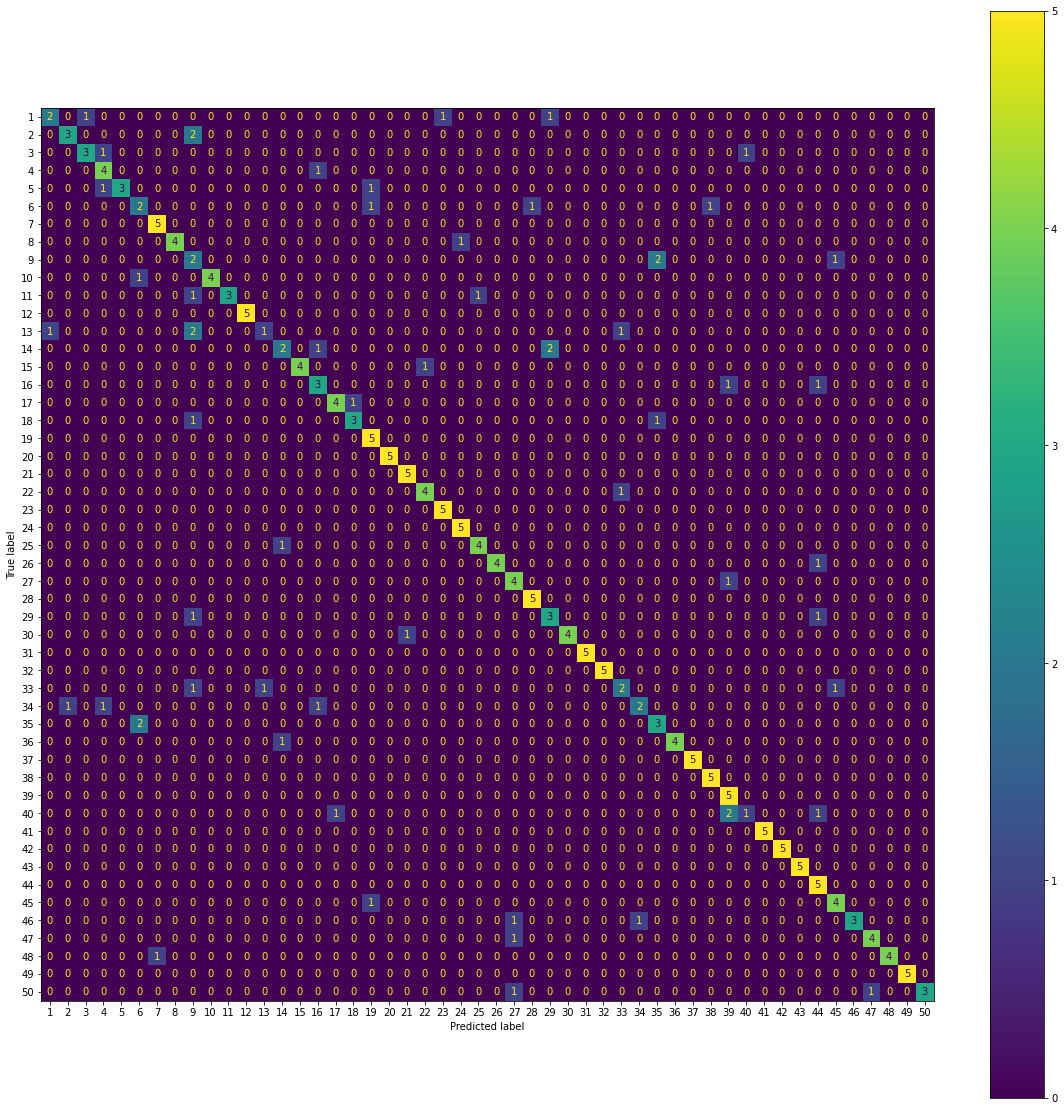

              precision    recall  f1-score   support

           1       0.67      0.40      0.50         5
           2       0.75      0.60      0.67         5
           3       0.75      0.60      0.67         5
           4       0.57      0.80      0.67         5
           5       1.00      0.60      0.75         5
           6       0.40      0.40      0.40         5
           7       0.83      1.00      0.91         5
           8       1.00      0.80      0.89         5
           9       0.20      0.40      0.27         5
          10       1.00      0.80      0.89         5
          11       1.00      0.60      0.75         5
          12       1.00      1.00      1.00         5
          13       0.50      0.20      0.29         5
          14       0.50      0.40      0.44         5
          15       1.00      0.80      0.89         5
          16       0.50      0.60      0.55         5
          17       0.80      0.80      0.80         5
          18       0.75    

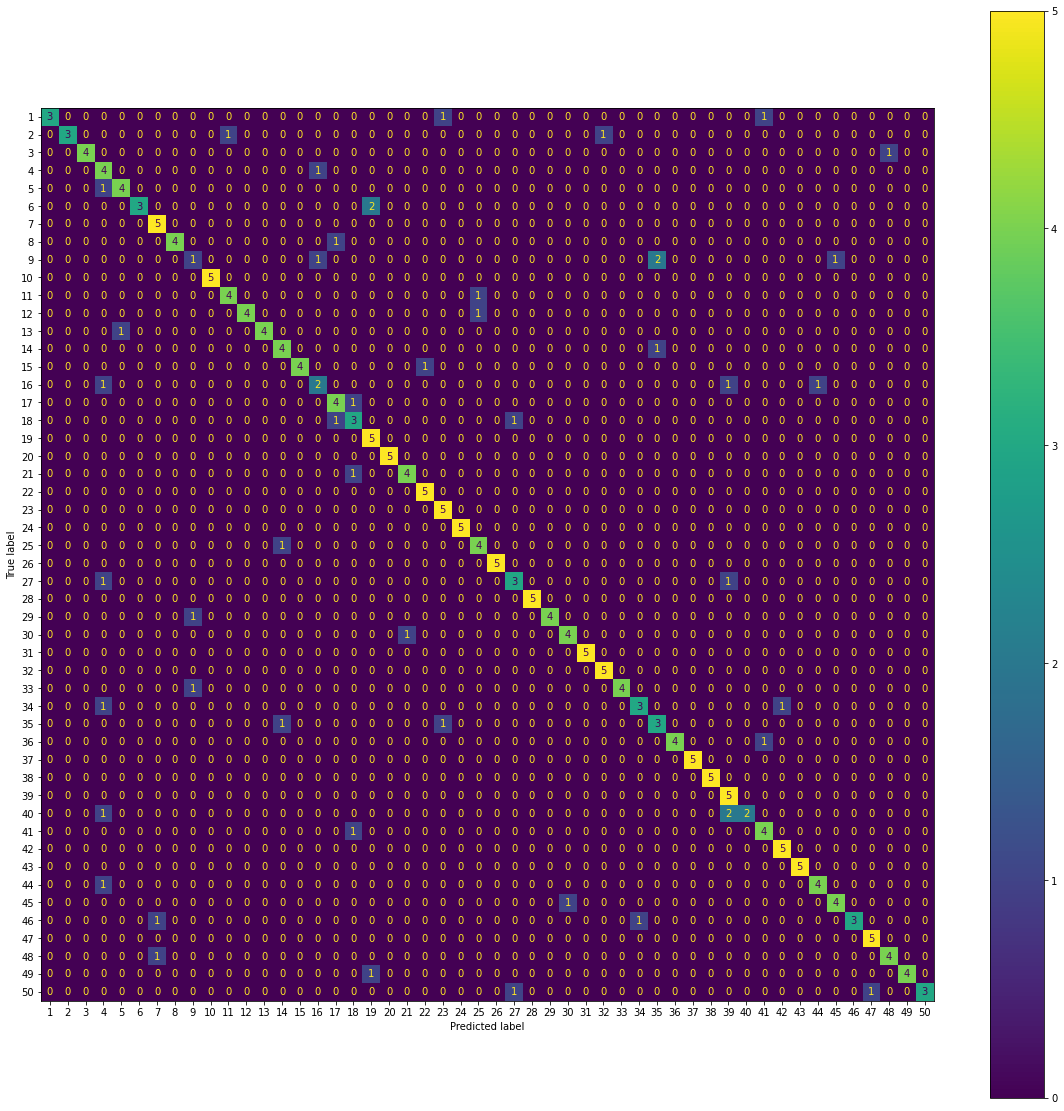

              precision    recall  f1-score   support

           1       1.00      0.60      0.75         5
           2       1.00      0.60      0.75         5
           3       1.00      0.80      0.89         5
           4       0.40      0.80      0.53         5
           5       0.80      0.80      0.80         5
           6       1.00      0.60      0.75         5
           7       0.71      1.00      0.83         5
           8       1.00      0.80      0.89         5
           9       0.33      0.20      0.25         5
          10       1.00      1.00      1.00         5
          11       0.80      0.80      0.80         5
          12       1.00      0.80      0.89         5
          13       1.00      0.80      0.89         5
          14       0.67      0.80      0.73         5
          15       1.00      0.80      0.89         5
          16       0.50      0.40      0.44         5
          17       0.67      0.80      0.73         5
          18       0.50    

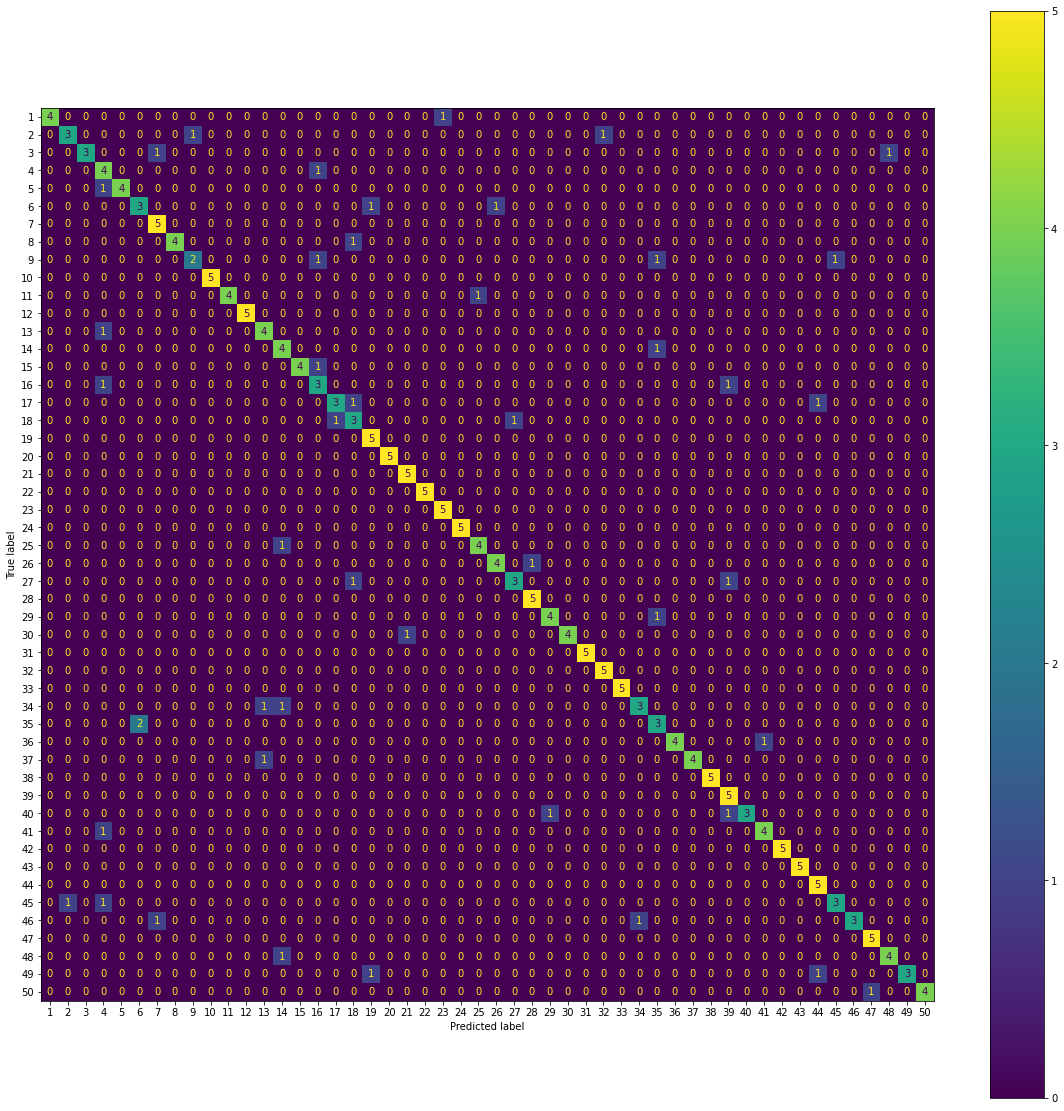

              precision    recall  f1-score   support

           1       1.00      0.80      0.89         5
           2       0.75      0.60      0.67         5
           3       1.00      0.60      0.75         5
           4       0.44      0.80      0.57         5
           5       1.00      0.80      0.89         5
           6       0.60      0.60      0.60         5
           7       0.71      1.00      0.83         5
           8       1.00      0.80      0.89         5
           9       0.67      0.40      0.50         5
          10       1.00      1.00      1.00         5
          11       1.00      0.80      0.89         5
          12       1.00      1.00      1.00         5
          13       0.67      0.80      0.73         5
          14       0.57      0.80      0.67         5
          15       1.00      0.80      0.89         5
          16       0.50      0.60      0.55         5
          17       0.75      0.60      0.67         5
          18       0.50    

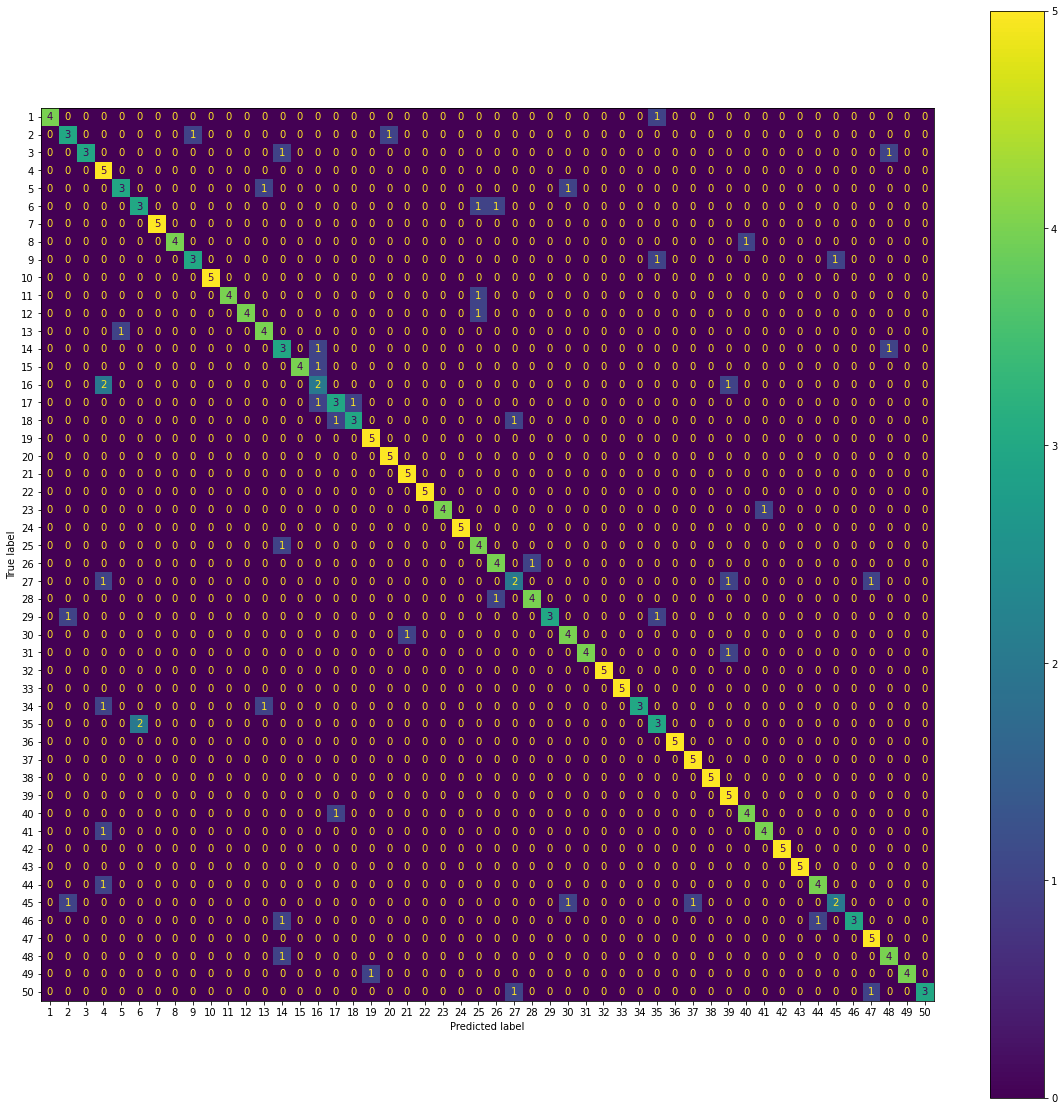

              precision    recall  f1-score   support

           1       1.00      0.80      0.89         5
           2       0.60      0.60      0.60         5
           3       1.00      0.60      0.75         5
           4       0.45      1.00      0.62         5
           5       0.75      0.60      0.67         5
           6       0.60      0.60      0.60         5
           7       1.00      1.00      1.00         5
           8       1.00      0.80      0.89         5
           9       0.75      0.60      0.67         5
          10       1.00      1.00      1.00         5
          11       1.00      0.80      0.89         5
          12       1.00      0.80      0.89         5
          13       0.67      0.80      0.73         5
          14       0.43      0.60      0.50         5
          15       1.00      0.80      0.89         5
          16       0.40      0.40      0.40         5
          17       0.60      0.60      0.60         5
          18       0.75    

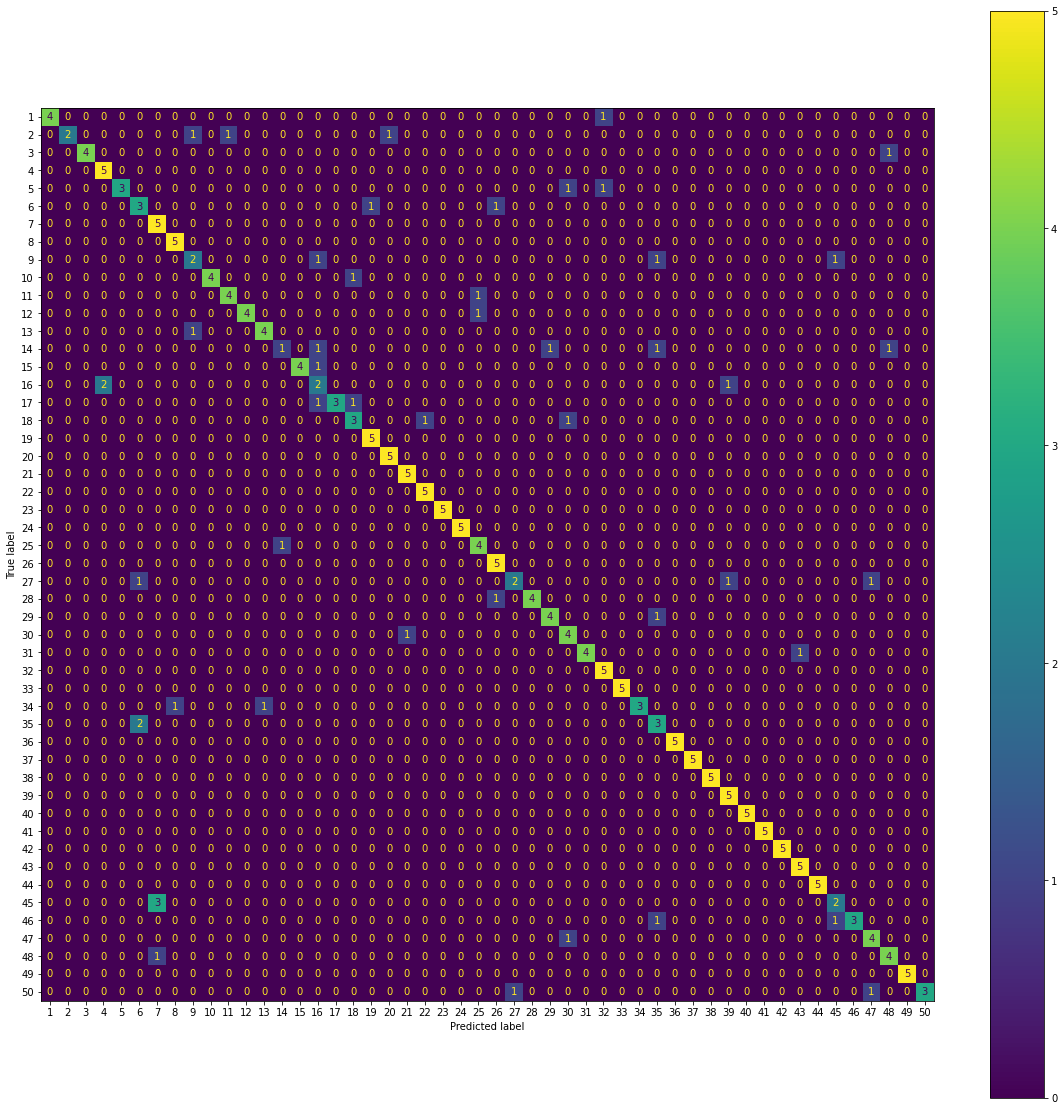

              precision    recall  f1-score   support

           1       1.00      0.80      0.89         5
           2       1.00      0.40      0.57         5
           3       1.00      0.80      0.89         5
           4       0.71      1.00      0.83         5
           5       1.00      0.60      0.75         5
           6       0.50      0.60      0.55         5
           7       0.56      1.00      0.71         5
           8       0.83      1.00      0.91         5
           9       0.50      0.40      0.44         5
          10       1.00      0.80      0.89         5
          11       0.80      0.80      0.80         5
          12       1.00      0.80      0.89         5
          13       0.80      0.80      0.80         5
          14       0.50      0.20      0.29         5
          15       1.00      0.80      0.89         5
          16       0.33      0.40      0.36         5
          17       1.00      0.60      0.75         5
          18       0.60    

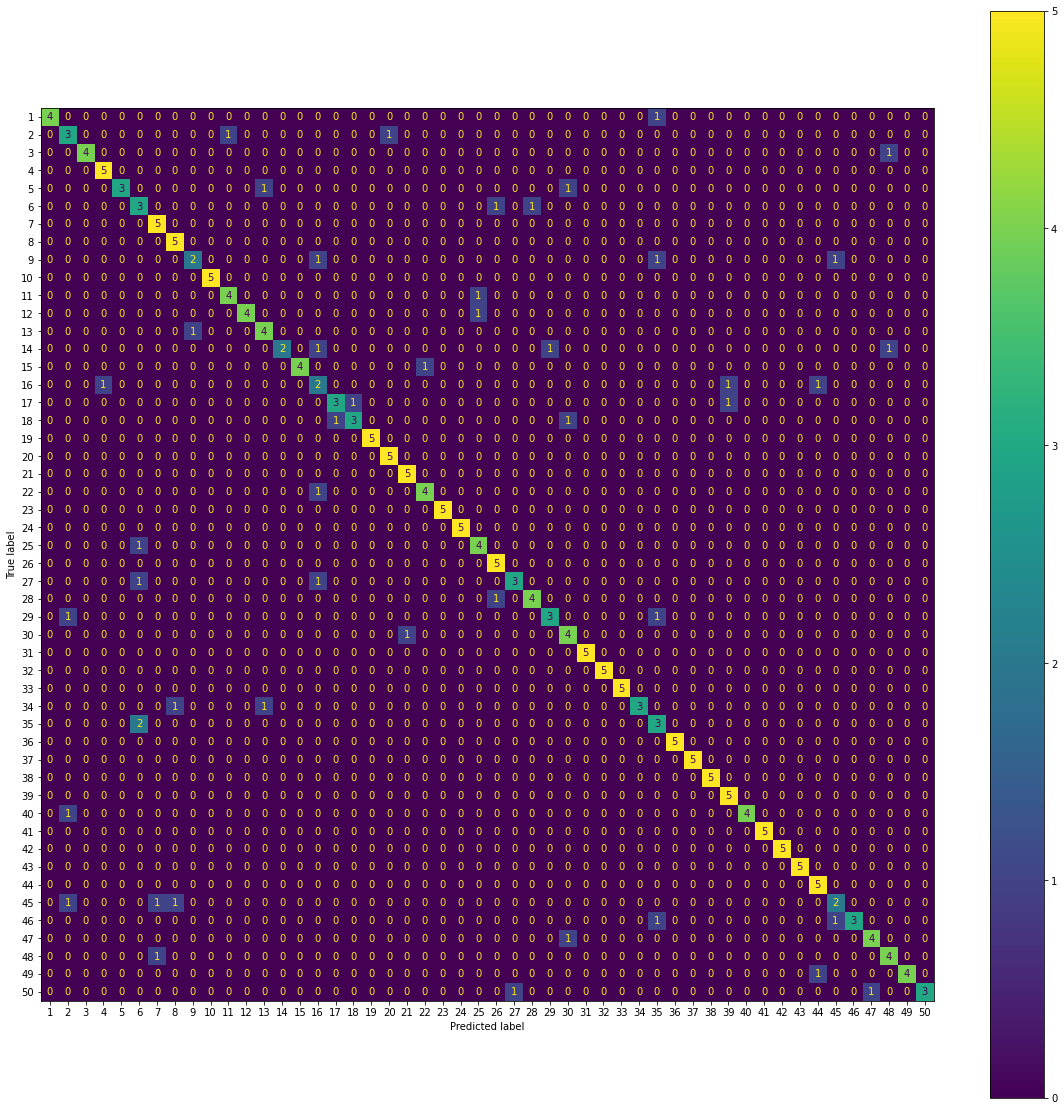

              precision    recall  f1-score   support

           1       1.00      0.80      0.89         5
           2       0.50      0.60      0.55         5
           3       1.00      0.80      0.89         5
           4       0.83      1.00      0.91         5
           5       1.00      0.60      0.75         5
           6       0.43      0.60      0.50         5
           7       0.71      1.00      0.83         5
           8       0.71      1.00      0.83         5
           9       0.67      0.40      0.50         5
          10       1.00      1.00      1.00         5
          11       0.80      0.80      0.80         5
          12       1.00      0.80      0.89         5
          13       0.67      0.80      0.73         5
          14       1.00      0.40      0.57         5
          15       1.00      0.80      0.89         5
          16       0.33      0.40      0.36         5
          17       0.75      0.60      0.67         5
          18       0.75    

In [54]:
ns = [10, 20, 30, 40, 50, 60, 70]

charcols = ['Model', '# principle components', 'Accuracy', 'Berekeningsduur', 'Berekeningsduur/fit']
chars = []

for n in ns:
    #Train het PCA algoritme op de training data
    print(f'LOGISTISCHE REGRESSIE MET {n} PRINCIPLE COMPONENTS')
    pca_model = PCA(n_components=n, svd_solver='full')
    pca_model.fit(X_train)
    
    #Reduceer het aantal dimensies van zowel de trainig set als de test set
    X_train_pca = pca_model.transform(X_train)
    X_test_pca = pca_model.transform(X_test)
    
    ss = StandardScaler()
    X_train_pca = ss.fit_transform(X_train_pca)
    X_test_pca = ss.transform(X_test_pca)
    
    start_clf1 = timeit.default_timer()
    gs1 = GridSearchCV(clf1, grid1, cv=8, n_jobs=-1, scoring='accuracy', verbose=1)
    gs1.fit(X_train_pca, y_train)
    stop_clf1 = timeit.default_timer()
    diff_clf1 = stop_clf1 - start_clf1
    diff_fit_clf1 = diff_clf1 / (len(ParameterGrid(grid1)) * 8)
    
    # Beste parameters en score
    print(f"Beste parameters:\t{gs1.best_params_}")
    print(f"Beste score: \t{gs1.best_score_}")
    
    # Confusion matrix
    print("Confusion matrix")
    logr_pred = (gs1.predict(X_test_pca))
    plt.rcParams["figure.figsize"] = (20,20)
    ConfusionMatrixDisplay.from_predictions(y_test, logr_pred)
    plt.show()
    
    # Classification report
    print(classification_report(y_test, logr_pred))
    
    # Characteristics array
    char = ['Logistische regressie', n, accuracy_score(y_test, logr_pred) * 100, diff_clf1, diff_fit_clf1]
    chars.append(char)

**Conclusie logistische regressie**  
De accuracy varieert rond de 80% voor de modellen. Een uitgebreider overzicht hiervan wordt weergegeven na support vector machines. De accuracy lijkt toe te nemen, naarmate meer principle components worden gebruikt, maar vanaf 50 PC's lijkt de accuracy te stagneren en soms zelfs opnieuw te verminderen.

#### Support Vector Machines
Naar analogie van logistische regressie worden nu ook support vector machines onderzocht.

Fitting 8 folds for each of 71 candidates, totalling 568 fits
Beste parameters:	{'C': 4.452222222222222, 'gamma': 0.01, 'kernel': 'rbf'}
Beste score: 	0.8902009728622631
Confusion matrix


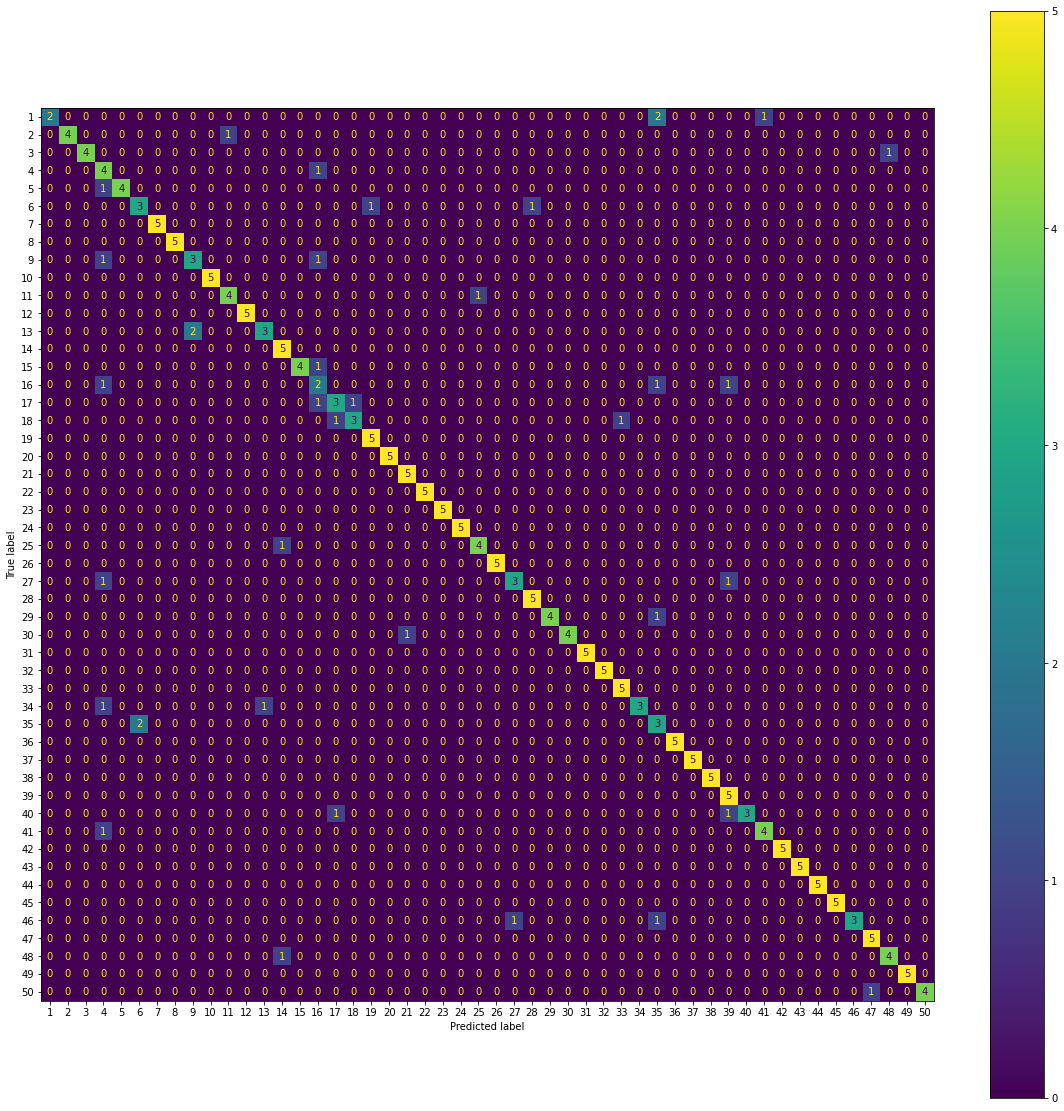

              precision    recall  f1-score   support

           1       1.00      0.80      0.89         5
           2       0.50      0.60      0.55         5
           3       1.00      0.80      0.89         5
           4       0.83      1.00      0.91         5
           5       1.00      0.60      0.75         5
           6       0.43      0.60      0.50         5
           7       0.71      1.00      0.83         5
           8       0.71      1.00      0.83         5
           9       0.67      0.40      0.50         5
          10       1.00      1.00      1.00         5
          11       0.80      0.80      0.80         5
          12       1.00      0.80      0.89         5
          13       0.67      0.80      0.73         5
          14       1.00      0.40      0.57         5
          15       1.00      0.80      0.89         5
          16       0.33      0.40      0.36         5
          17       0.75      0.60      0.67         5
          18       0.75    

In [55]:
# SVM voor 40 PC's
pca_model = PCA(n_components=40, svd_solver='full')
pca_model.fit(X_train)
    
#Reduceer het aantal dimensies van zowel de trainig set als de test set
X_train_pca = pca_model.transform(X_train)
X_test_pca = pca_model.transform(X_test)

ss = StandardScaler()
X_train_pca = ss.fit_transform(X_train_pca)
X_test_pca = ss.transform(X_test_pca)

start_clf2 = timeit.default_timer()

gs2 = GridSearchCV(clf2, grid2, cv=8, n_jobs=-1, scoring='accuracy', verbose=1)
gs2.fit(X_train_pca, y_train)

stop_clf2 = timeit.default_timer()
diff_clf2 = stop_clf2 - start_clf2
diff_fit_clf2 = diff_clf2 / (len(ParameterGrid(grid2)) * 8)

# Beste parameters en score
print(f"Beste parameters:\t{gs2.best_params_}")
print(f"Beste score: \t{gs2.best_score_}")

# Confusion matrix
print("Confusion matrix")
svc_pred = (gs2.predict(X_test_pca))
plt.rcParams["figure.figsize"] = (20,20)
ConfusionMatrixDisplay.from_predictions(y_test, svc_pred)
plt.show()

# Classification report
print(classification_report(y_test, logr_pred))

Het beste model kent een accuracy van 81%. Ook hier laat de confusionmatrix zien dat voor enkele gezichten, het model moeilijkheden heeft om juist te classificeren.

In de volgende stap worden opnieuw verschillende aantallen van principle components getest. De resultaten worden naar analogie van logistische regressie onder elkaar weergegeven. De belangrijkste gegevens worden opgeslagen in een lijst. Na het onderzoeken van support vector machines zal deze lijst worden omgezet tot een DataFrame voor bijkomende analyse.

SVM MET 10 PRINCIPLE COMPONENTS
Fitting 8 folds for each of 71 candidates, totalling 568 fits
Beste parameters:	{'C': 6.673333333333333, 'gamma': 0.1, 'kernel': 'rbf'}
Beste score: 	0.8623911930363544
Confusion matrix


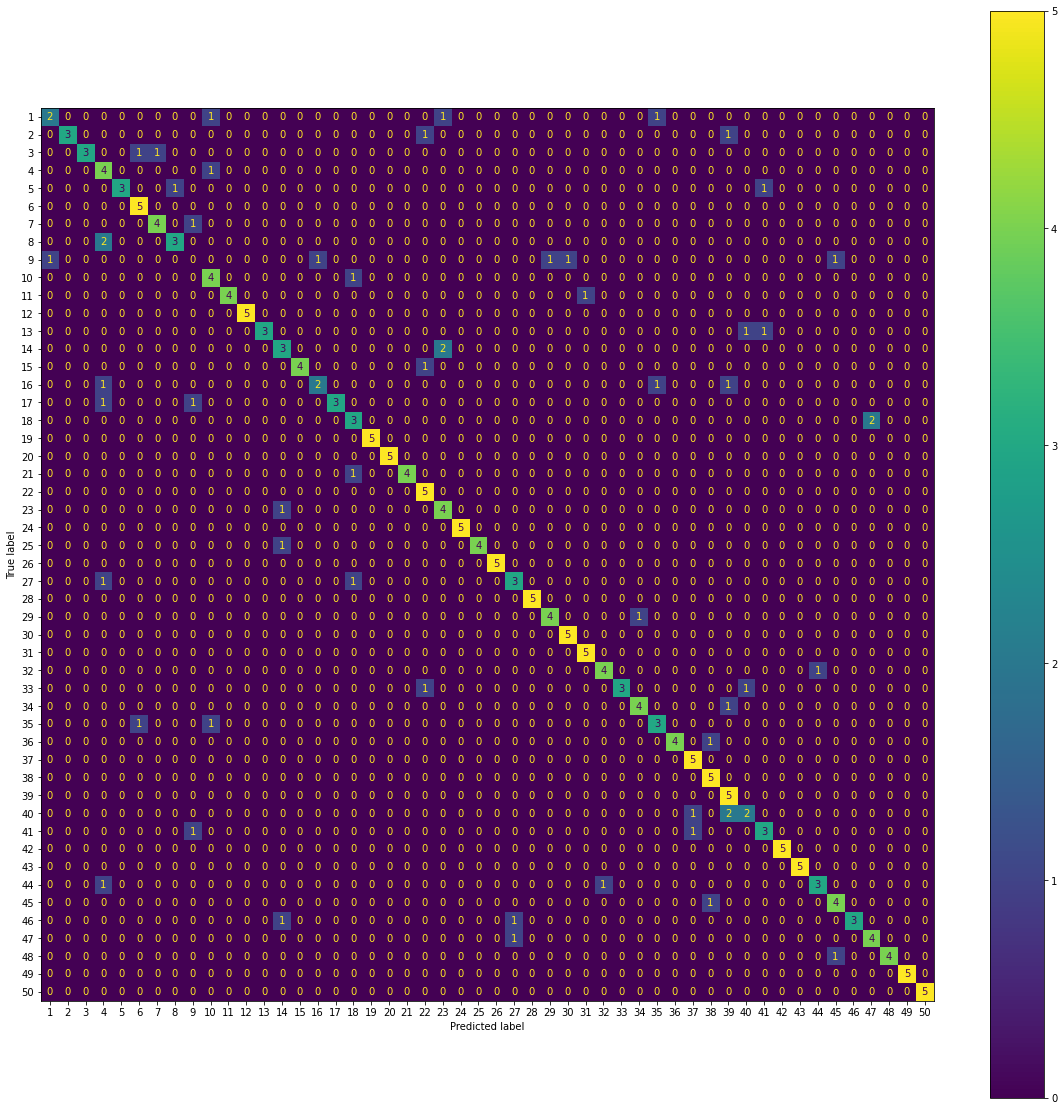

              precision    recall  f1-score   support

           1       0.67      0.40      0.50         5
           2       1.00      0.60      0.75         5
           3       1.00      0.60      0.75         5
           4       0.40      0.80      0.53         5
           5       1.00      0.60      0.75         5
           6       0.71      1.00      0.83         5
           7       0.80      0.80      0.80         5
           8       0.75      0.60      0.67         5
           9       0.00      0.00      0.00         5
          10       0.57      0.80      0.67         5
          11       1.00      0.80      0.89         5
          12       1.00      1.00      1.00         5
          13       1.00      0.60      0.75         5
          14       0.50      0.60      0.55         5
          15       1.00      0.80      0.89         5
          16       0.67      0.40      0.50         5
          17       1.00      0.60      0.75         5
          18       0.50    

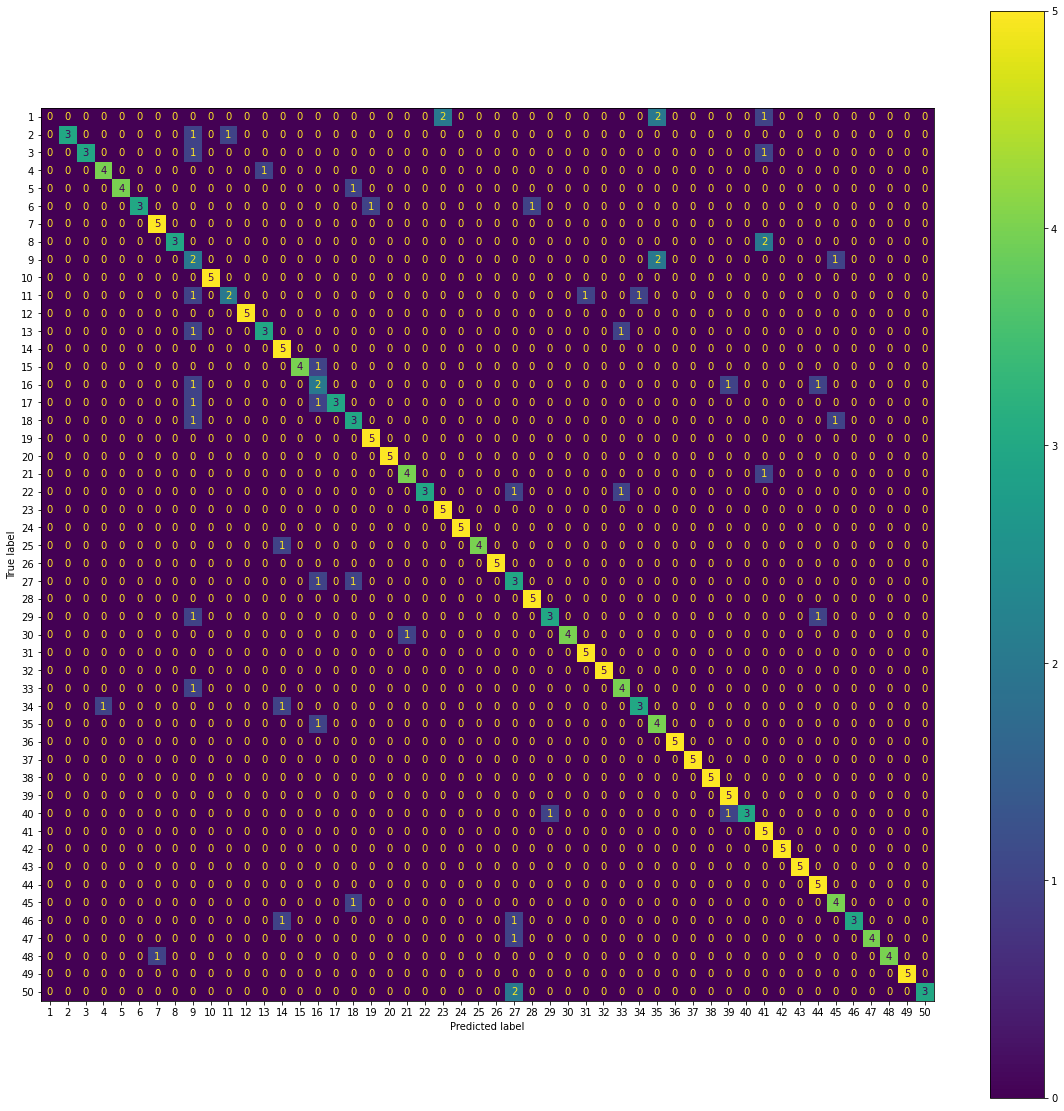

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         5
           2       1.00      0.60      0.75         5
           3       1.00      0.60      0.75         5
           4       0.80      0.80      0.80         5
           5       1.00      0.80      0.89         5
           6       1.00      0.60      0.75         5
           7       0.83      1.00      0.91         5
           8       1.00      0.60      0.75         5
           9       0.18      0.40      0.25         5
          10       1.00      1.00      1.00         5
          11       0.67      0.40      0.50         5
          12       1.00      1.00      1.00         5
          13       0.75      0.60      0.67         5
          14       0.62      1.00      0.77         5
          15       1.00      0.80      0.89         5
          16       0.33      0.40      0.36         5
          17       1.00      0.60      0.75         5
          18       0.50    

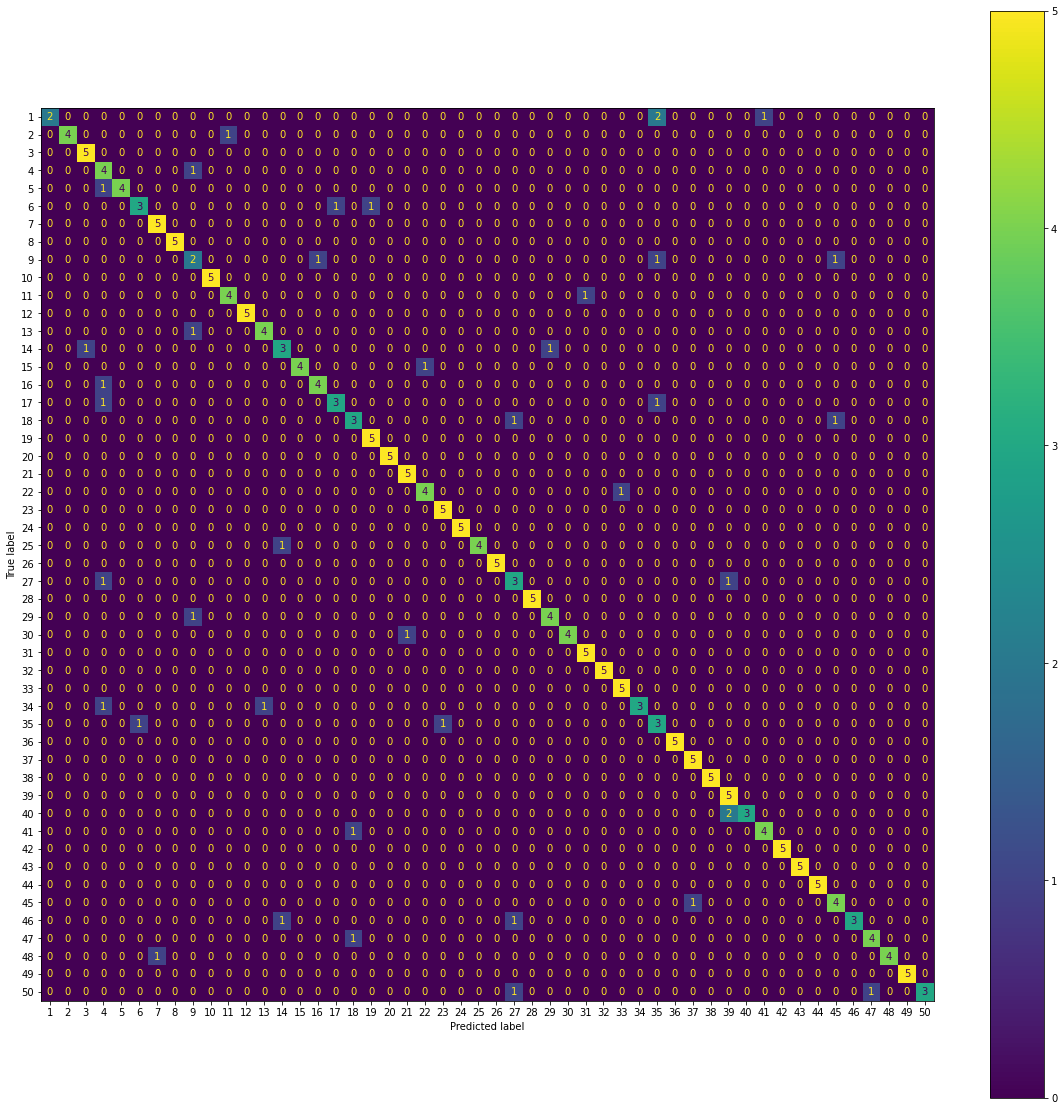

              precision    recall  f1-score   support

           1       1.00      0.40      0.57         5
           2       1.00      0.80      0.89         5
           3       0.83      1.00      0.91         5
           4       0.44      0.80      0.57         5
           5       1.00      0.80      0.89         5
           6       0.75      0.60      0.67         5
           7       0.83      1.00      0.91         5
           8       1.00      1.00      1.00         5
           9       0.40      0.40      0.40         5
          10       1.00      1.00      1.00         5
          11       0.80      0.80      0.80         5
          12       1.00      1.00      1.00         5
          13       0.80      0.80      0.80         5
          14       0.60      0.60      0.60         5
          15       1.00      0.80      0.89         5
          16       0.80      0.80      0.80         5
          17       0.75      0.60      0.67         5
          18       0.60    

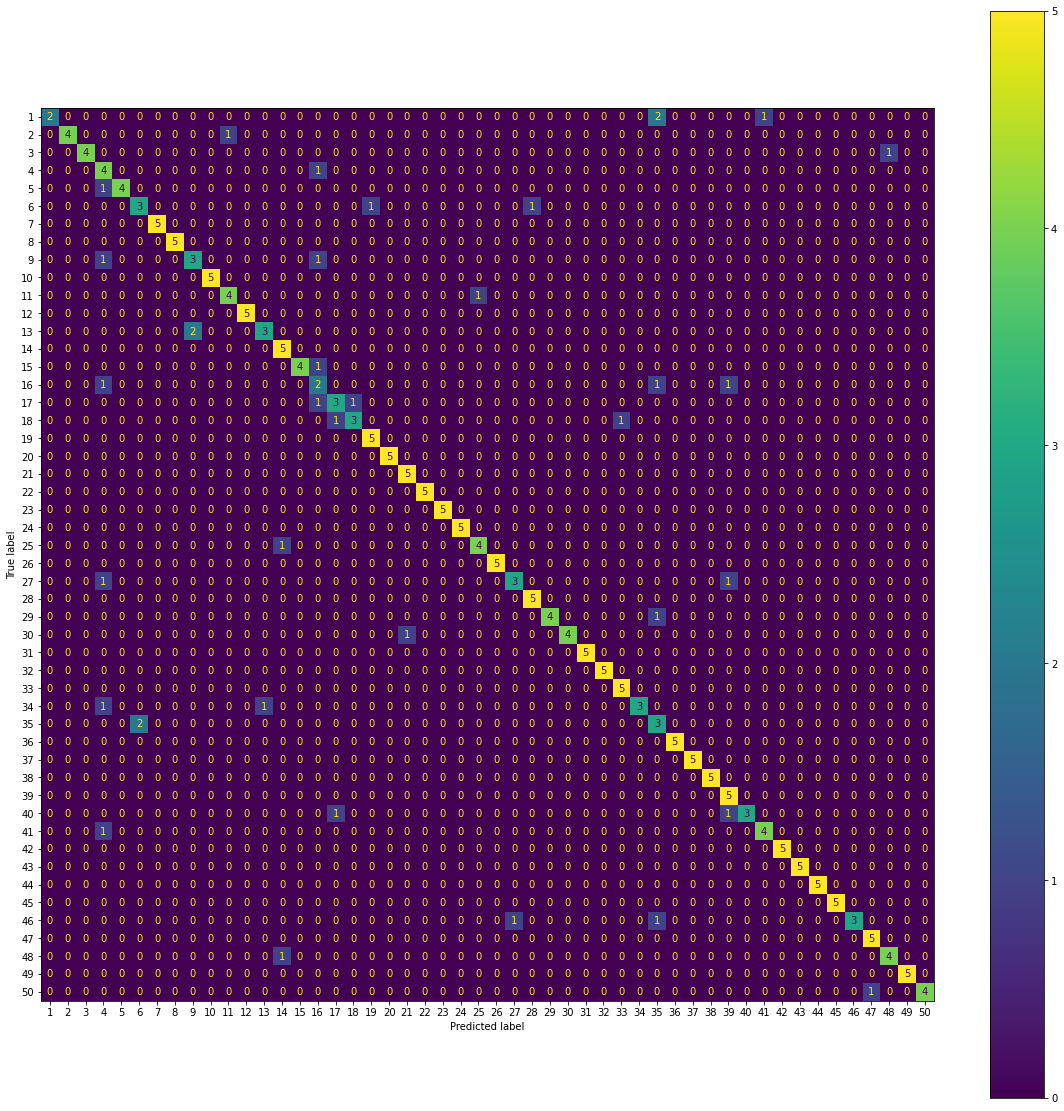

              precision    recall  f1-score   support

           1       1.00      0.40      0.57         5
           2       1.00      0.80      0.89         5
           3       1.00      0.80      0.89         5
           4       0.40      0.80      0.53         5
           5       1.00      0.80      0.89         5
           6       0.60      0.60      0.60         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5
           9       0.60      0.60      0.60         5
          10       1.00      1.00      1.00         5
          11       0.80      0.80      0.80         5
          12       1.00      1.00      1.00         5
          13       0.75      0.60      0.67         5
          14       0.71      1.00      0.83         5
          15       1.00      0.80      0.89         5
          16       0.33      0.40      0.36         5
          17       0.60      0.60      0.60         5
          18       0.75    

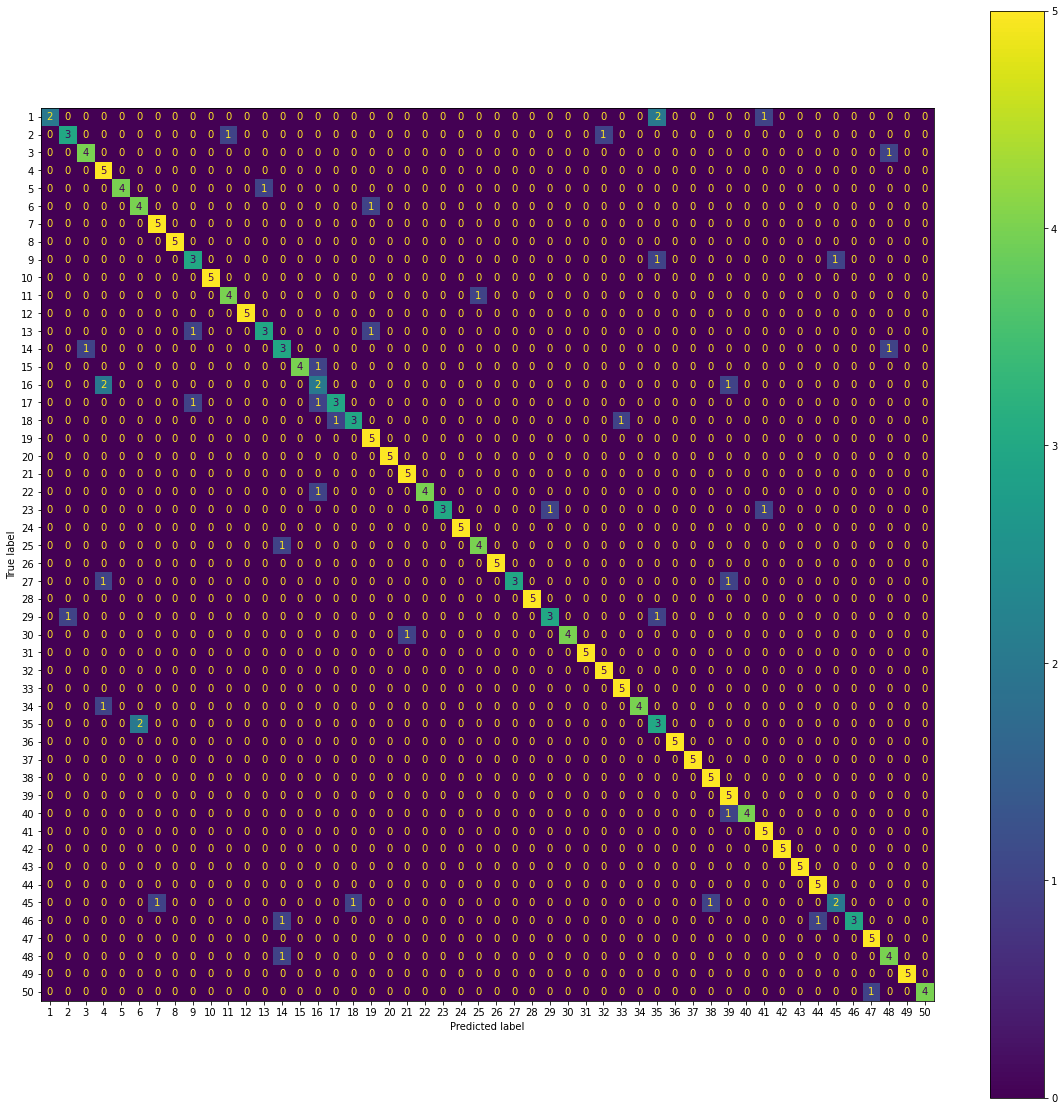

              precision    recall  f1-score   support

           1       1.00      0.40      0.57         5
           2       0.75      0.60      0.67         5
           3       0.80      0.80      0.80         5
           4       0.56      1.00      0.71         5
           5       1.00      0.80      0.89         5
           6       0.67      0.80      0.73         5
           7       0.83      1.00      0.91         5
           8       1.00      1.00      1.00         5
           9       0.60      0.60      0.60         5
          10       1.00      1.00      1.00         5
          11       0.80      0.80      0.80         5
          12       1.00      1.00      1.00         5
          13       0.75      0.60      0.67         5
          14       0.50      0.60      0.55         5
          15       1.00      0.80      0.89         5
          16       0.40      0.40      0.40         5
          17       0.75      0.60      0.67         5
          18       0.75    

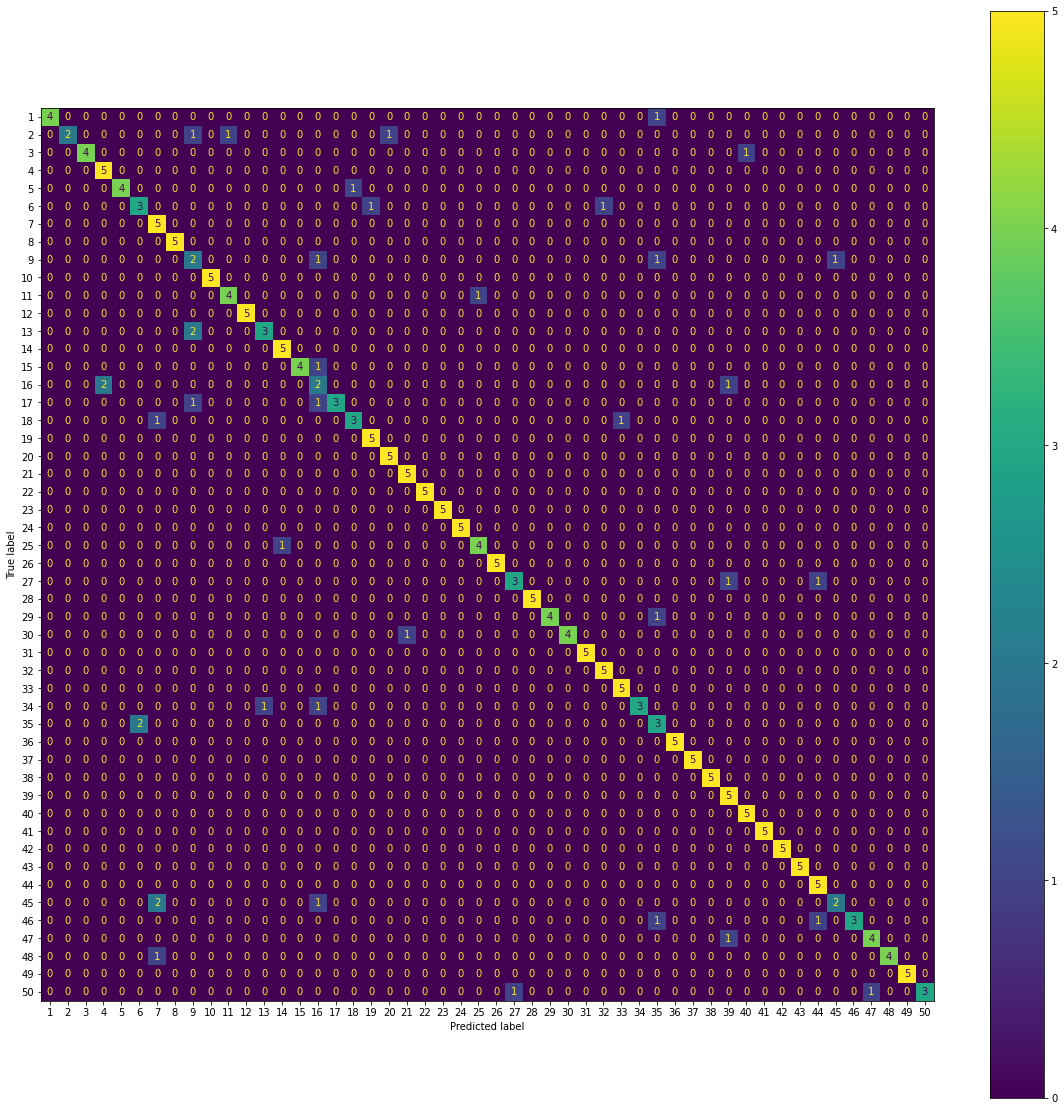

              precision    recall  f1-score   support

           1       1.00      0.80      0.89         5
           2       1.00      0.40      0.57         5
           3       1.00      0.80      0.89         5
           4       0.71      1.00      0.83         5
           5       1.00      0.80      0.89         5
           6       0.60      0.60      0.60         5
           7       0.56      1.00      0.71         5
           8       1.00      1.00      1.00         5
           9       0.33      0.40      0.36         5
          10       1.00      1.00      1.00         5
          11       0.80      0.80      0.80         5
          12       1.00      1.00      1.00         5
          13       0.75      0.60      0.67         5
          14       0.83      1.00      0.91         5
          15       1.00      0.80      0.89         5
          16       0.29      0.40      0.33         5
          17       1.00      0.60      0.75         5
          18       0.75    

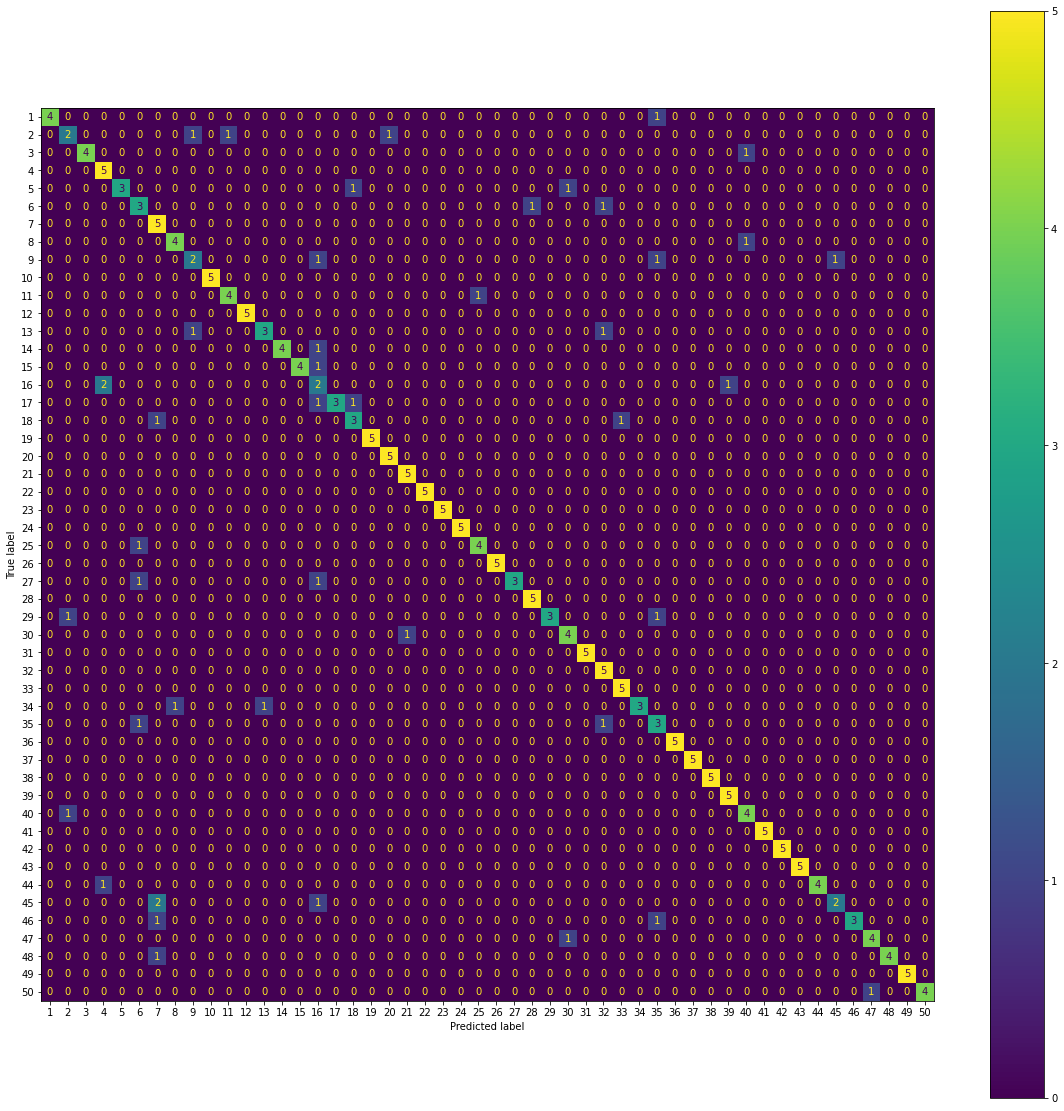

              precision    recall  f1-score   support

           1       1.00      0.80      0.89         5
           2       0.50      0.40      0.44         5
           3       1.00      0.80      0.89         5
           4       0.62      1.00      0.77         5
           5       1.00      0.60      0.75         5
           6       0.50      0.60      0.55         5
           7       0.50      1.00      0.67         5
           8       0.80      0.80      0.80         5
           9       0.50      0.40      0.44         5
          10       1.00      1.00      1.00         5
          11       0.80      0.80      0.80         5
          12       1.00      1.00      1.00         5
          13       0.75      0.60      0.67         5
          14       1.00      0.80      0.89         5
          15       1.00      0.80      0.89         5
          16       0.25      0.40      0.31         5
          17       1.00      0.60      0.75         5
          18       0.60    

In [56]:
# SVM

for n in ns:
    #Train het PCA algoritme op de training data
    print(f'SVM MET {n} PRINCIPLE COMPONENTS')
    pca_model = PCA(n_components=n, svd_solver='full')
    pca_model.fit(X_train)
    
    #Reduceer het aantal dimensies van zowel de trainig set als de test set
    X_train_pca = pca_model.transform(X_train)
    X_test_pca = pca_model.transform(X_test)
    
    ss = StandardScaler()
    X_train_pca = ss.fit_transform(X_train_pca)
    X_test_pca = ss.transform(X_test_pca)
    
    start_clf2 = timeit.default_timer()
    gs2 = GridSearchCV(clf2, grid2, cv=8, n_jobs=-1, scoring='accuracy', verbose=1)
    gs2.fit(X_train_pca, y_train)
    stop_clf2 = timeit.default_timer()
    diff_clf2 = stop_clf2 - start_clf2
    diff_fit_clf2 = diff_clf2 / (len(ParameterGrid(grid2)) * 8)
    
    # Beste parameters en score
    print(f"Beste parameters:\t{gs2.best_params_}")
    print(f"Beste score: \t{gs2.best_score_}")
    
    # Confusion matrix
    print("Confusion matrix")
    svc_pred = (gs2.predict(X_test_pca))
    plt.rcParams["figure.figsize"] = (20,20)
    ConfusionMatrixDisplay.from_predictions(y_test, svc_pred)
    plt.show()

    # Classification report
    print(classification_report(y_test, svc_pred, zero_division=0))
    
    # Characteristics array
    char = ['Support Vector Machine', n, accuracy_score(y_test, svc_pred) * 100, diff_clf2, diff_fit_clf2]
    chars.append(char)






In [57]:
characteristics = pd.DataFrame(chars, columns=charcols)
characteristics

Model  # principle components  Accuracy  Berekeningsduur  \
0    Logistische regressie                      10      68.8        26.411016   
1    Logistische regressie                      20      76.0        32.204388   
2    Logistische regressie                      30      80.4        44.858274   
3    Logistische regressie                      40      81.6        49.981842   
4    Logistische regressie                      50      79.2        59.567323   
5    Logistische regressie                      60      80.4        71.839562   
6    Logistische regressie                      70      80.8        87.199519   
7   Support Vector Machine                      10      77.2         6.751297   
8   Support Vector Machine                      20      78.8         8.293107   
9   Support Vector Machine                      30      83.6         9.498107   
10  Support Vector Machine                      40      84.8        11.448762   
11  Support Vector Machine                      50      82.8        10.654371   
12  Support Vector Machine                      60      84.0        11.866620   
13  Support Vector Machine                      70      82.0        11.501649   

    Berekeningsduur/fit  
0              0.165069  
1              0.201277  
2              0.280364  
3              0.312387  
4              0.372296  
5              0.448997  
6              0.544997  
7              0.011886  
8              0.014601  
9              0.016722  
10             0.020156  
11             0.018758  
12             0.020892  
13             0.020249

**Conclusie SVM en logistische regressie**  
Zowel logistische regressie als SVM doen het niet heel geweldig op de test sets. De accuracy circuleren rond de 80%, met uitzonderingen van de lage aantal PC's. SVM doet het hier iets beter dan logistisch regressie. Naast de fluctuatie in accuracy wordt ook bij de berekeningsduur opgemerkt dat de snelheid toeneemt naarmate de toename van het aantal PC's. Wederom doet SVM het hier beter (de berekening duurt korter).

Op basis van de berekeningsduur en de beste accuracy wordt geopteerd voor een SVM-model op basis van 40 principle components.

#### RandomForestClassifier
Naar analogie van de vorige classifiers wordt ook een RandomForestClassifier getraind. Hyperparameter tuning en cross validation gebeurt door middel van GridSearch.

Geziend de berekeningsduur worden geen variabele PC's getest.

Fitting 6 folds for each of 864 candidates, totalling 5184 fits
Beste parameters:	{'class_weight': 'balanced', 'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 251}
Beste score: 	0.8822432587492829
Confusion matrix


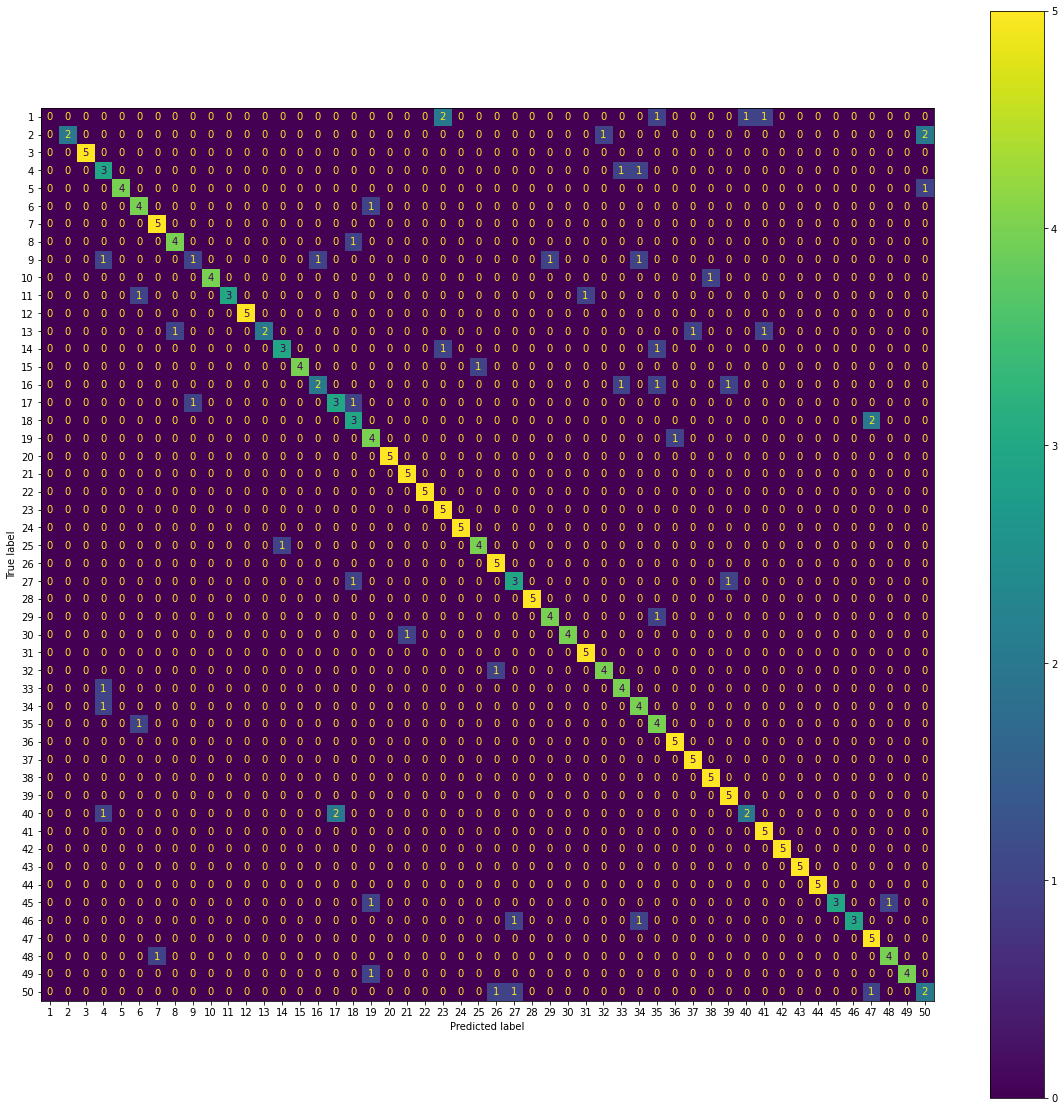

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         5
           2       1.00      0.40      0.57         5
           3       1.00      1.00      1.00         5
           4       0.43      0.60      0.50         5
           5       1.00      0.80      0.89         5
           6       0.67      0.80      0.73         5
           7       0.83      1.00      0.91         5
           8       0.80      0.80      0.80         5
           9       0.50      0.20      0.29         5
          10       1.00      0.80      0.89         5
          11       1.00      0.60      0.75         5
          12       1.00      1.00      1.00         5
          13       1.00      0.40      0.57         5
          14       0.75      0.60      0.67         5
          15       1.00      0.80      0.89         5
          16       0.67      0.40      0.50         5
          17       0.60      0.60      0.60         5
          18       0.50    

In [151]:
# RFC
pca_model = PCA(n_components=40, svd_solver='full')
pca_model.fit(X_train)
    
#Reduceer het aantal dimensies van zowel de trainig set als de test set
X_train_pca = pca_model.transform(X_train)
X_test_pca = pca_model.transform(X_test)

ss = StandardScaler()
X_train_pca = ss.fit_transform(X_train_pca)
X_test_pca = ss.transform(X_test_pca)

gs3 = GridSearchCV(clf3, grid3, cv=6, n_jobs=-1, scoring='accuracy', verbose=1)
gs3.fit(X_train_pca, y_train)

# Beste parameters en score
print(f"Beste parameters:\t{gs3.best_params_}")
print(f"Beste score: \t{gs3.best_score_}")

# Confusion matrix
print("Confusion matrix")
rfc_pred = (gs3.predict(X_test_pca))
plt.rcParams["figure.figsize"] = (20,20)
ConfusionMatrixDisplay.from_predictions(y_test, rfc_pred)
plt.show()

# Classification report
print(classification_report(y_test, rfc_pred, zero_division=0))

Zoals hierboven reeds vermeld, heeft RFC een langere berekeningsduur nodig in vergelijking met de andere geteste classifiers. De accuracy is lager dan bij SVM, namelijk 78%. Rekening houdend met de berekeningsduur lijkt RFC daarom een minder geschikte classifier voor deze dataset.

#### Verkleerd geklassificeerde gezichten
In onderstaande codeblokken wordt getracht enkele verkeerd geclassificeerde gezichten weer te geven. Hiervoor wordt gebruik gemaakt van de resultaten van SVM

In [146]:
# verkeerd geklassificeerde gezichten:
wrong_arr = []
labels = []
for inputs, prediction, label in zip(X_test_pca, svc_pred, y_test):
    if prediction != label:
        wrong_row = list(inputs)
        wrong_arr.append(wrong_row)
        labels.append(label)

In [147]:
number = len(wrong_arr)
print(f'Aantal verkeerd geclassificeerde gezichten:\t{number}')

Aantal verkeerd geclassificeerde gezichten:	249


Voorbeeld van verkeerd geklassificeerd gezicht 1
Echte label van het gezicht: 	1


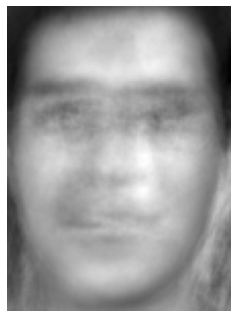

In [148]:
print('Voorbeeld van verkeerd geklassificeerd gezicht 1')
image_reconstructed = pca_model.inverse_transform(wrong_arr[0])
plt.rcParams["figure.figsize"] = (4,6)
plt.imshow(image_reconstructed.reshape((150,110)),cmap = 'gray')
plt.axis('off')
print(f'Echte label van het gezicht: \t{labels[0]}')

Voorbeeld van verkeerd geklassificeerd gezicht 2
Echte label van het gezicht: 	1


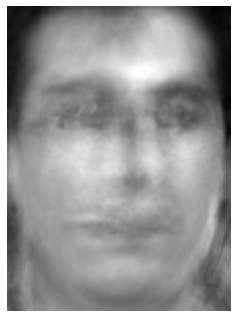

In [149]:
print('Voorbeeld van verkeerd geklassificeerd gezicht 2')
image_reconstructed = pca_model.inverse_transform(wrong_arr[1])
plt.rcParams["figure.figsize"] = (4,6)
plt.imshow(image_reconstructed.reshape((150,110)),cmap = 'gray')
plt.axis('off')
print(f'Echte label van het gezicht: \t{labels[1]}')

Voorbeeld van verkeerd geklassificeerd gezicht 3
Echte label van het gezicht: 	1


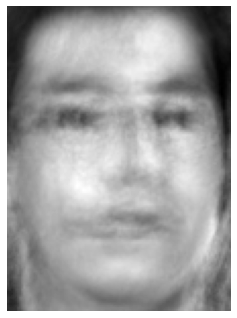

In [150]:
print('Voorbeeld van verkeerd geklassificeerd gezicht 3')
image_reconstructed = pca_model.inverse_transform(wrong_arr[2])
plt.rcParams["figure.figsize"] = (4,6)
plt.imshow(image_reconstructed.reshape((150,110)),cmap = 'gray')
plt.axis('off')
print(f'Echte label van het gezicht: \t{labels[2]}')

#### Ensemble methodes
**Opgave**  
Kijk of je met ensemble methodes zoals boosting de accuracy nog kan verhogen.

**Uitwerking**  
Achtereenvolgens worden GradientBoosting en AdaBoost getest. Vervolgens wordt onderzocht of Stacking de accuracy kan verhogen. Een conclusie volgt pas na deze laatste.

Confusion matrix


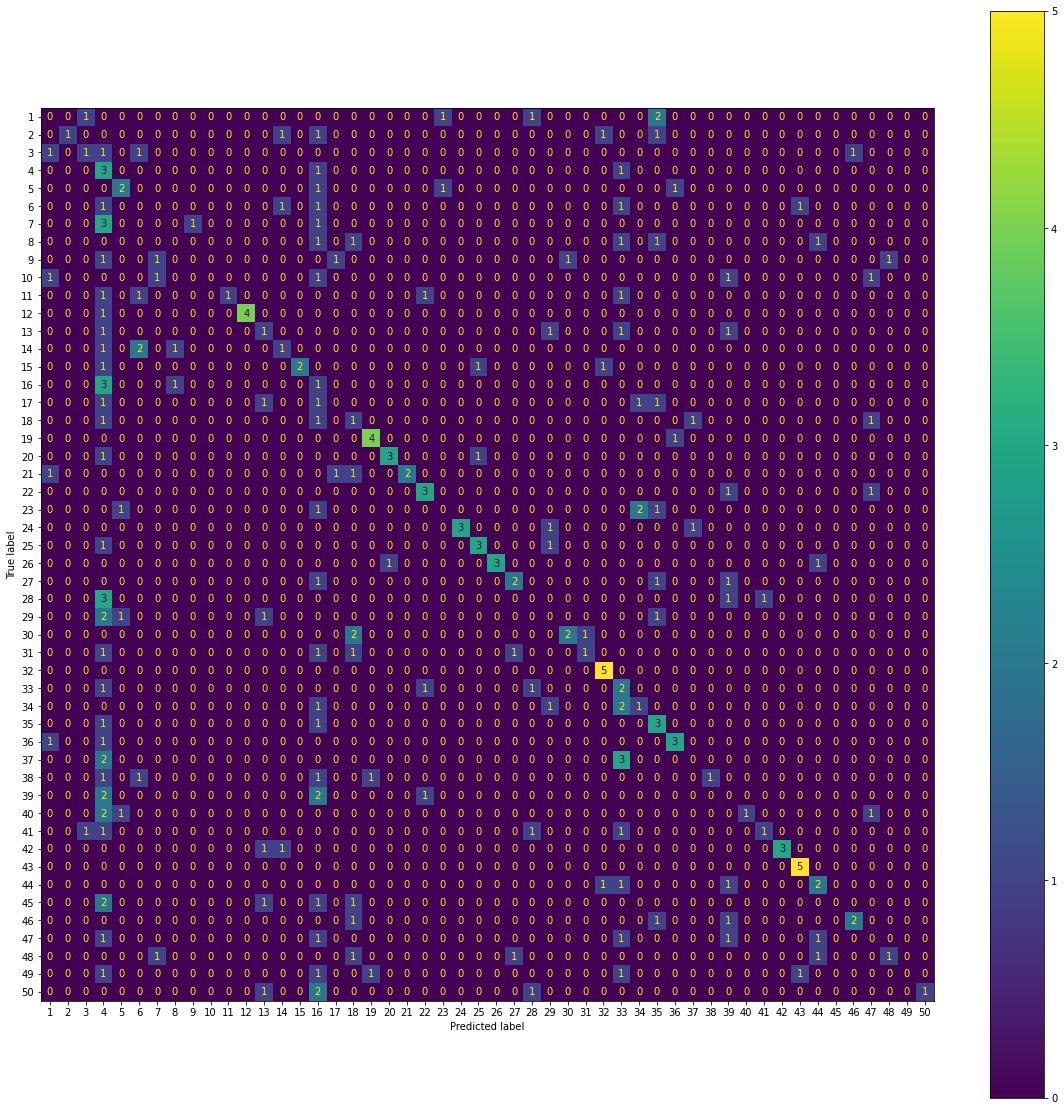

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         5
           2       1.00      0.20      0.33         5
           3       0.33      0.20      0.25         5
           4       0.07      0.60      0.13         5
           5       0.40      0.40      0.40         5
           6       0.00      0.00      0.00         5
           7       0.00      0.00      0.00         5
           8       0.00      0.00      0.00         5
           9       0.00      0.00      0.00         5
          10       0.00      0.00      0.00         5
          11       1.00      0.20      0.33         5
          12       1.00      0.80      0.89         5
          13       0.17      0.20      0.18         5
          14       0.25      0.20      0.22         5
          15       1.00      0.40      0.57         5
          16       0.04      0.20      0.07         5
          17       0.00      0.00      0.00         5
          18       0.11    

In [37]:
# Ensemble methodes
start_clf3 = timeit.default_timer()

clf_gradientboost = GradientBoostingClassifier(n_estimators=600,learning_rate=0.95)
clf_gradientboost.fit(X_train_pca,y_train)

stop_clf3 = timeit.default_timer()
diff_clf3 = stop_clf3 - start_clf3

# Confusion matrix
print("Confusion matrix")
logr_pred = (clf_gradientboost.predict(X_test_pca))
plt.rcParams["figure.figsize"] = (20,20)
ConfusionMatrixDisplay.from_predictions(y_test, logr_pred)
plt.show()

# Classification report
print(classification_report(y_test, logr_pred, zero_division=0))

Confusion matrix


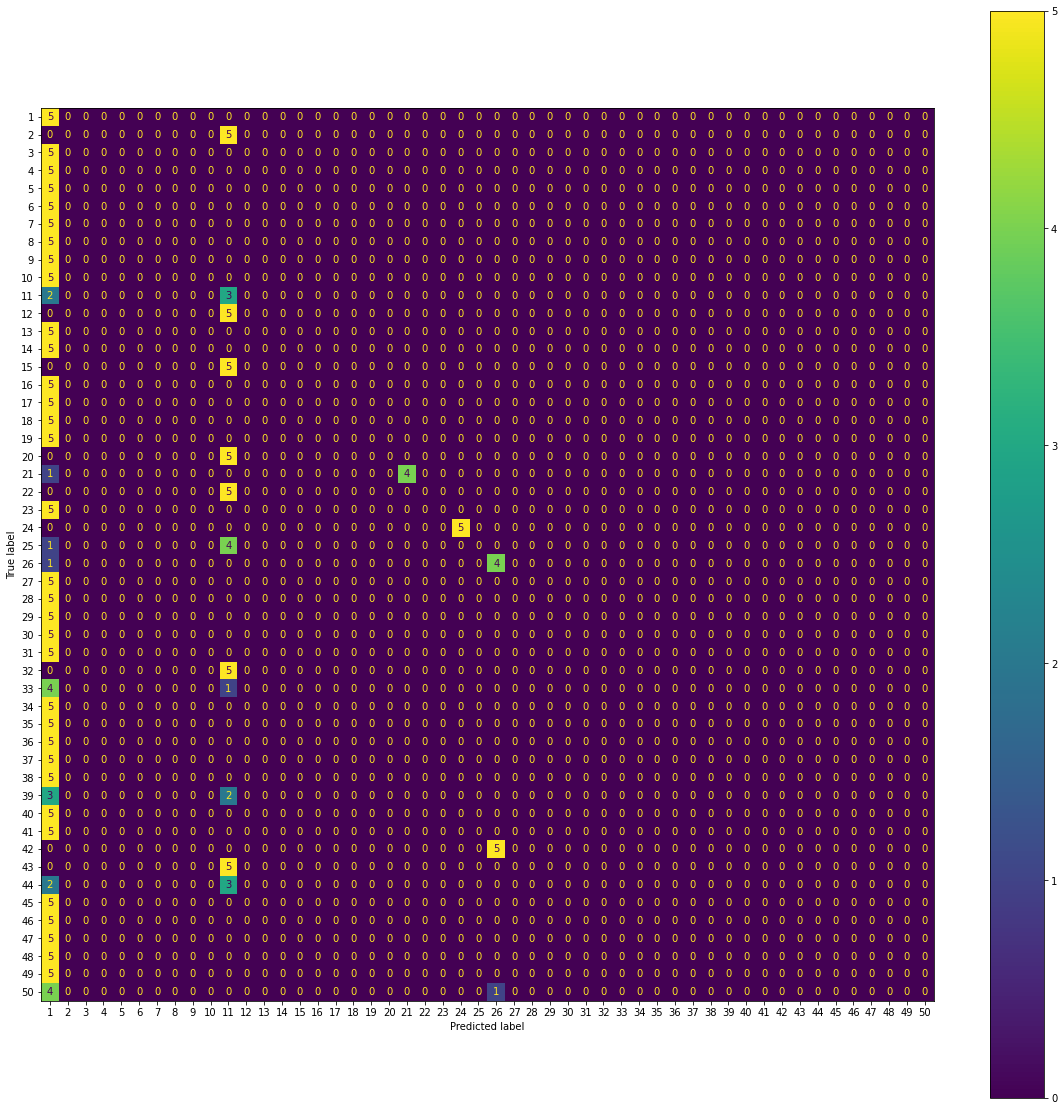

              precision    recall  f1-score   support

           1       0.03      1.00      0.05         5
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00         5
           7       0.00      0.00      0.00         5
           8       0.00      0.00      0.00         5
           9       0.00      0.00      0.00         5
          10       0.00      0.00      0.00         5
          11       0.06      0.60      0.11         5
          12       0.00      0.00      0.00         5
          13       0.00      0.00      0.00         5
          14       0.00      0.00      0.00         5
          15       0.00      0.00      0.00         5
          16       0.00      0.00      0.00         5
          17       0.00      0.00      0.00         5
          18       0.00    

In [40]:
# Boosting (Adaboost)
clf_adaboost = AdaBoostClassifier(n_estimators=100,learning_rate=0.90)
clf_adaboost.fit(X_train_pca,y_train)

# Confusion matrix
print("Confusion matrix")
ada_pred = (clf_adaboost.predict(X_test_pca))
ConfusionMatrixDisplay.from_predictions(y_test, ada_pred)  
plt.show()

# Classification report
print(classification_report(y_test, ada_pred, zero_division=0))
print(accuracy_score(y_test, ada_pred) * 100) 

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion matrix


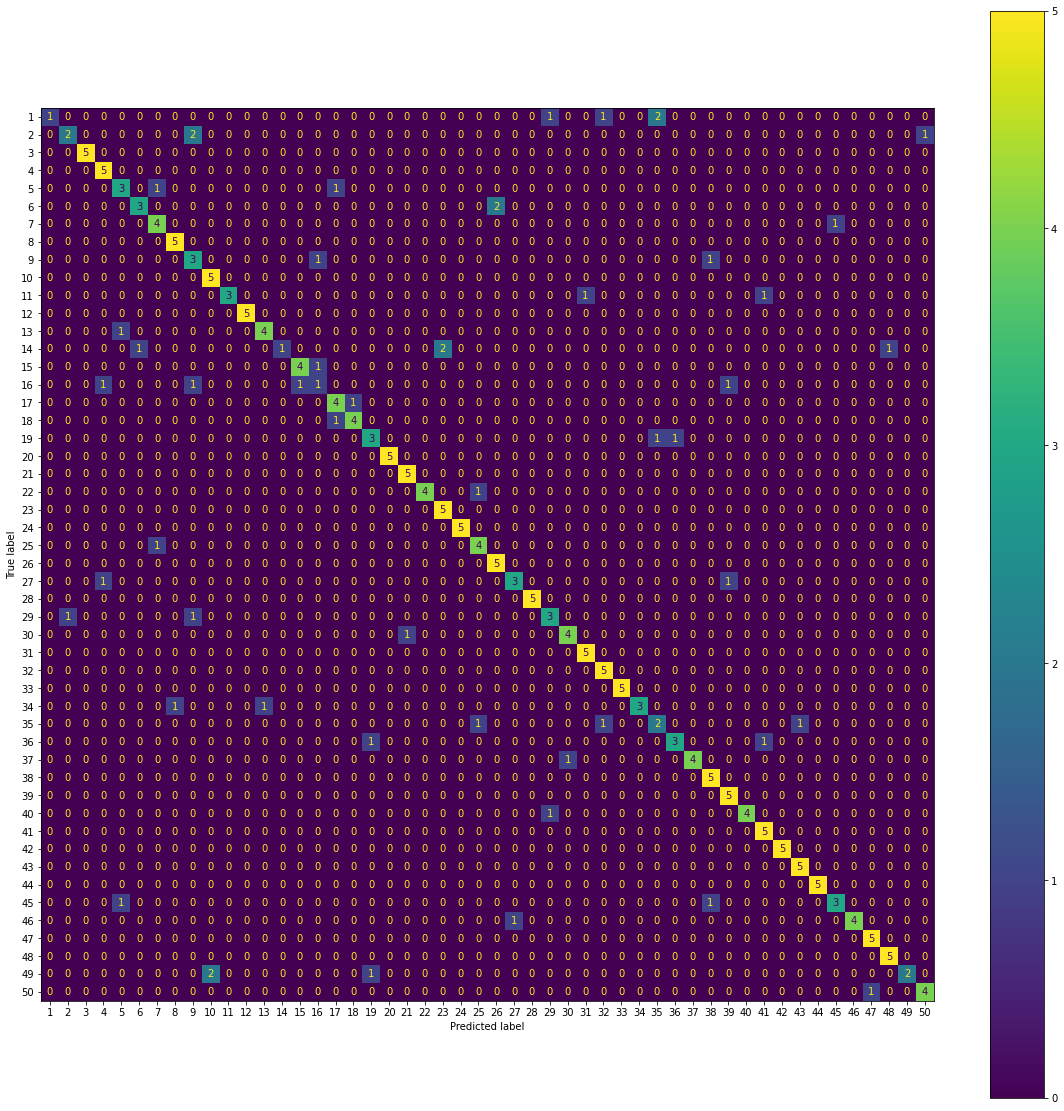

              precision    recall  f1-score   support

           1       1.00      0.20      0.33         5
           2       0.67      0.40      0.50         5
           3       1.00      1.00      1.00         5
           4       0.71      1.00      0.83         5
           5       0.60      0.60      0.60         5
           6       0.75      0.60      0.67         5
           7       0.67      0.80      0.73         5
           8       0.83      1.00      0.91         5
           9       0.43      0.60      0.50         5
          10       0.71      1.00      0.83         5
          11       1.00      0.60      0.75         5
          12       1.00      1.00      1.00         5
          13       0.80      0.80      0.80         5
          14       1.00      0.20      0.33         5
          15       0.80      0.80      0.80         5
          16       0.33      0.20      0.25         5
          17       0.67      0.80      0.73         5
          18       0.80    

In [62]:
estimators = [
    ('logreg', LogisticRegression(C=0.464158883361278, solver='lbfgs')),
    ('svc', SVC(C=4.452222222222222, kernel='rbf', gamma=0.01, class_weight=None)),
    ('nb' , GaussianNB()),
    ('rfc', RandomForestClassifier(n_estimators = 751, class_weight='balanced', max_depth= None, max_features='log2', min_samples_leaf= 2, min_samples_split=5)),
    ('adab', AdaBoostClassifier(n_estimators=100,learning_rate=0.90)),
    ('gb', GradientBoostingClassifier(n_estimators=600,learning_rate=0.95))
]

lr = LogisticRegression()

stacked_model = StackingClassifier(estimators=estimators, final_estimator=lr, cv=8, n_jobs=-1)
stacked_model.fit(X_train_pca, y_train)

# Confusion matrix
print("Confusion matrix")
stack_pred = (stacked_model.predict(X_test_pca))
ConfusionMatrixDisplay.from_predictions(y_test, stack_pred)  
plt.show()

# Classification report
print(classification_report(y_test, stack_pred))
print(accuracy_score(y_test, stack_pred) * 100)

**Conclusie ensemble methodes**  
Boosting doet het ronduit slecht en neigt naar *overfitting*. De accuracy voor GradientBoosting bedraagt 30% en voor Adaboost slechts 8%. Bij stacking hebben we opnieuw een betere accuracy van 78,8%, maar de accuracy is nog steeds slechter dan bij SVM.

##  Uitbreiding - Face detection
**Opgave**  
De bedoeling van face detection is het kunnen lokaliseren van gezichten in een afbeelding. Tegenwoordig bestaan hiervoor bestaan speciale getrainde neurale netwerken die hier bijzonder goed in zijn die later in deep learning aan bod zullen komen.
Wat deze opdracht gaan we een minder geavanceerde werkwijze hanteren:

- Maak een training set die bestaat uit foto's van gezichten enerzijds maar ook uit foto's van niet gezichten anderzijds.Online zijn verschillende gezichtsdatasets te vinden. Bijvoorbeeld: https://lionbridge.ai/datasets/5-million-faces-top-15-free-image-datasets-for-facial-recognition/ en http://shuoyang1213.me/WIDERFACE/. Dataset met afbeeldingen van niet-gezichten zijn vrij makkelijk te vinden. Je kan ook enkel hoge resolutie afbeeldingen verzamelen waarop geen gezichten staan. Hieruit kan je heel wat subafbeeldingen knippen die je gebruikt voor de negatieve klasse.
- Train een classifier (naar eigen keuze) die met een zo hoog mogelijke accuraatheid gezichten van niet-gezichten kan onderscheiden.
- Test deze classifier om een idee te hebben van de classifiation accuracy. 
- Indien de performantie voldoende hoog is kan je een sliding window detector implementeren. Dit betekent dat je de test-afbeelding meerdere keren afscant met een sliding window van verschillende groottes. De classifier zal voor elke positie van het sliding window een classificatie doen van de subimage die onder het window is gelegen. Teken een bounding box wanneer de subimage een gezicht bevat.

Voor het tekenen van een bounding box kan de volgende code gebruikt worden:

```python
def rectangle_perimeter(r0, c0, width, height, shape=None, clip=False):
    rr, cc = [r0, r0 + width, r0 + width, r0], [c0, c0, c0 + height, c0 + height]
    return skimage.draw.polygon_perimeter(rr, cc, shape=shape, clip=clip)

# drawing the bounding box:
rr, cc = rectangle_perimeter(y, x, w, w)
image_detected[rr,cc] =255

```

Test de face detector op een afbeelding waarop 1 of meerdere personen staan afgebeeld en kijk of de gezichten worden gedetecteerd. 

Een voorbeeld:

![alt text](./Jupyter_Images/Face_Detection.png) 


Extra uitbreiding:

Probleem: omdat we de afbeelding meerdere keren afscannen, telkens met windows van verschillende grootte is het goed mogelijk dat er meerdere bounding boxes worden geteked rond hetzelfde gezicht. Zoek naar een manier om meerdere bounding boxes die bij hetzelfde gezicht horen samen te voegen tot 1 bounding box.
Een veel gebruikte techniek is Non-Maximum Suppression: https://www.pyimagesearch.com/2014/11/17/non-maximum-suppression-object-detection-python/ en https://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/.


### Inlezen van images
Van de Kaggle website worden 1081 images van gezichten ingeladen. Deze worden aangevuld met 1081 afbeeldingen van niet-gezichten. Het gaat hierbij om bergen, bossen, huizen, ... Hieronder worden ze ingeladen. Naar analogie met de vorige opdracht worden de afbeeldingen herschaald (naar 150x150 pixels). Vervolgens wordt er een training en test set gemaakt. 

In [2]:
# Uitwerking face detection
# Creëren van de dataset
# Inlezen van de face images
images = [] # empty list
y = [] # empty list (0 no face, 1 face)

path = "./Train_faces/"
valid_images = [".jpg",".gif",".png"]

for f in os.listdir(path):
    ext = os.path.splitext(f)[1]
    if ext.lower() not in valid_images:
        continue
    images.append(imread(os.path.join(path,f),as_gray=True))
    y.append(1)
   
     
# Inlezen van de no face images
path = "./Train_no_faces/"
valid_images = [".jpg",".gif",".png"]
counter = 0
for f in os.listdir(path):
    if counter < 1081:
        ext = os.path.splitext(f)[1]
        if ext.lower() not in valid_images:
            continue
        images.append(imread(os.path.join(path,f),as_gray=True))
        y.append(0)
        counter += 1
    else:
        break
    
print("Aantal images: ", len(images))

Aantal images:  2162


In [3]:
pd.DataFrame(y).value_counts()

0    1081
1    1081
dtype: int64

In [4]:
# Resize images
images_resized = [transform.resize(image, (150,150), mode='constant') for image in images]

In [5]:
X = np.array([image.reshape(1,-1).tolist() for image in images_resized]).reshape(len(images_resized),150*150)

In [6]:
X.shape

(2162, 22500)

In [7]:
# Splitsen in training en test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

### Dimensionaliteitsreductie met PCA
De afbeelding worden herleid tot hun principle components. Bij een eerste snelle doorloop werd snel duidelijk dat accuracy een issue is in deze opdracht. Daarom wordt er voor iets meer PC's gegaan. Het aantal wordt op 100 vastgelegd.

Na het transformeren worden de data eveneens geschaald.

In [8]:
# Dimensionality reduction: Principle Component Analysis met 40 componenten
n = 100

#Train het PCA algoritme op de training data
pca_model = PCA(n_components=n, svd_solver='full')
pca_model.fit(X_train)

#Reduceer het aantal dimensies van zowel de trainig set als de test set
X_train_pca = pca_model.transform(X_train)
X_test_pca = pca_model.transform(X_test)

In [9]:
# Schalen van de PC's
ss = StandardScaler()
X_train_pca = ss.fit_transform(X_train_pca)
X_test_pca = ss.transform(X_test_pca)

### Classificatie
Er worden enkele classifiers getraind. Deze zijn beperkt tot logistische regressie en SVM, aangezien de vorige opdracht liet blijken dat Ensemble methodes en RandomForestClassifiers minder geschikt lijken.

In [10]:
# Initiatie van classifiers
clf1 = LogisticRegression(max_iter=100000, class_weight='balanced')
clf2 = SVC(max_iter=1000000000, class_weight='balanced')

In [11]:
# Initiatie van grids
grid1 = {"C": np.logspace(-2,3,10), 
         "solver": ["lbfgs", "sag"]}

grid2 = [
    {
        'kernel': ['linear'],
        'C': np.logspace(-3,3,11)},
    {
        'kernel': ['rbf'], 
        'C': np.linspace(0.01,20,10), 
        'gamma': [0.0001, 0.001, 0.01, 0.1, 0.2]},
    {
        'kernel': ['poly'],
        'C': np.linspace(0.01,20,10)}
]

Fitting 8 folds for each of 20 candidates, totalling 160 fits
Beste parameters:	{'C': 0.01, 'solver': 'lbfgs'}
Beste score: 	0.8537927376481491
Confusion matrix


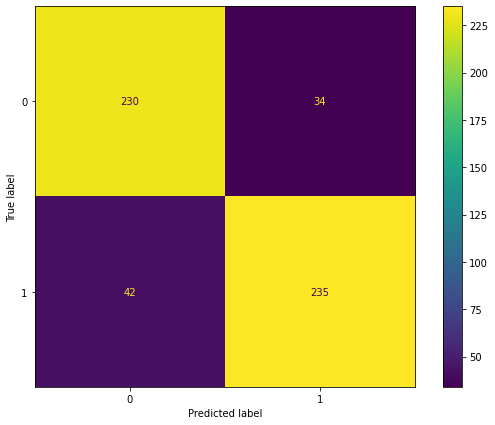

              precision    recall  f1-score   support

           0       0.85      0.87      0.86       264
           1       0.87      0.85      0.86       277

    accuracy                           0.86       541
   macro avg       0.86      0.86      0.86       541
weighted avg       0.86      0.86      0.86       541



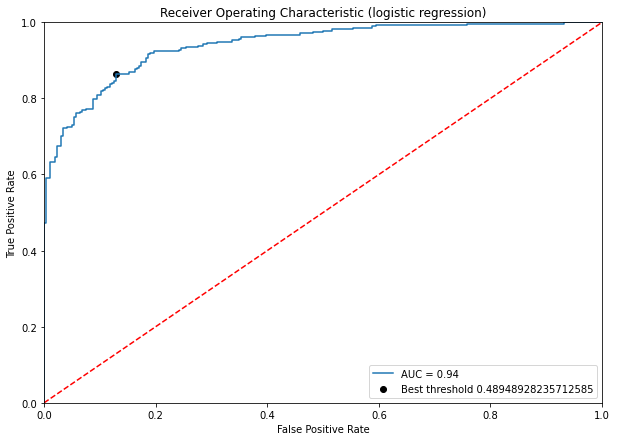

In [162]:
# Gridsearch Logistische regressie
gs1 = GridSearchCV(clf1, grid1, cv=8, n_jobs=-1, scoring='accuracy', verbose=1)
gs1.fit(X_train_pca, y_train)

# Beste parameters en score
print(f"Beste parameters:\t{gs1.best_params_}")
print(f"Beste score: \t{gs1.best_score_}")

# Confusion matrix
print("Confusion matrix")
logr_pred = (gs1.predict(X_test_pca))
plt.rcParams["figure.figsize"] = (10,7)
ConfusionMatrixDisplay.from_predictions(y_test, logr_pred)
plt.show()

# Classification report
print(classification_report(y_test, logr_pred))

# ROC en AUC
logr_probs = gs1.predict_proba(X_test_pca)
logr_preds = logr_probs[:,1]
logr_fpr, logr_tpr, logr_threshold = roc_curve(y_test, logr_preds)
logr_roc_auc = auc(logr_fpr, logr_tpr)
logr_gmeans = np.sqrt(logr_tpr * (1-logr_fpr))
logr_ix = np.argmax(logr_gmeans)


plt.title(f'Receiver Operating Characteristic (logistic regression)')
plt.plot(logr_fpr, logr_tpr, label = f'AUC = {logr_roc_auc:.2f}')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.scatter(logr_fpr[logr_ix], logr_tpr[logr_ix], marker='o', color='black', label=f'Best threshold {logr_threshold[logr_ix]}')
plt.legend(loc = 'lower right')
plt.show()

Fitting 6 folds for each of 71 candidates, totalling 426 fits
Beste parameters:	{'C': 2.231111111111111, 'gamma': 0.01, 'kernel': 'rbf'}
Beste score: 	0.9160994943282766
Confusion matrix


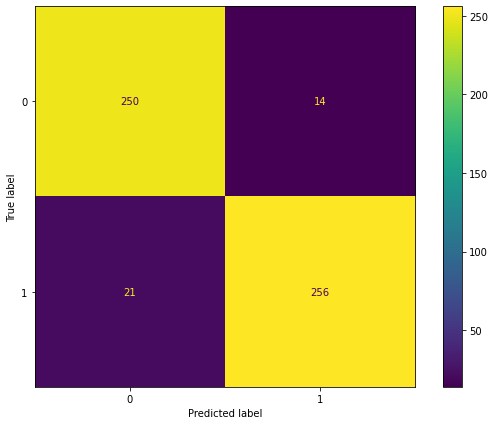

              precision    recall  f1-score   support

           0       0.92      0.95      0.93       264
           1       0.95      0.92      0.94       277

    accuracy                           0.94       541
   macro avg       0.94      0.94      0.94       541
weighted avg       0.94      0.94      0.94       541



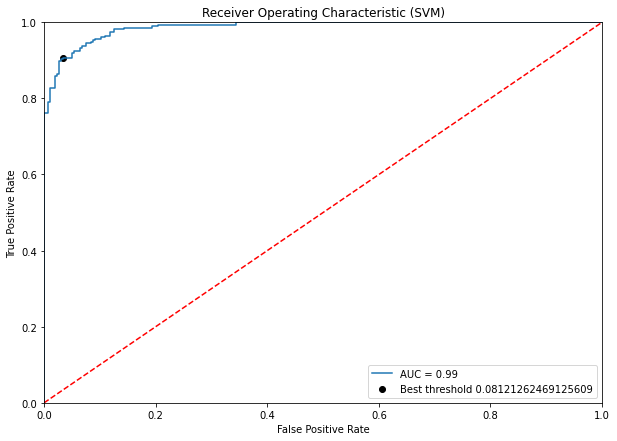

In [13]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter("ignore", category=ConvergenceWarning)
# Gridsearch SVM
gs2 = GridSearchCV(clf2, grid2, cv=6, n_jobs=-1, scoring='accuracy', verbose=1)
gs2.fit(X_train_pca, y_train)
        
# Beste parameters en score
print(f"Beste parameters:\t{gs2.best_params_}")
print(f"Beste score: \t{gs2.best_score_}")
  
# Confusion matrix
print("Confusion matrix")
svc_pred = (gs2.predict(X_test_pca))
plt.rcParams["figure.figsize"] = (10,7)
ConfusionMatrixDisplay.from_predictions(y_test, svc_pred)
plt.show()
      
# Classification report
print(classification_report(y_test, svc_pred))
       
# ROC en AUC
svm_preds = gs2.decision_function(X_test_pca)
svm_fpr, svm_tpr, svm_threshold = roc_curve(y_test, svm_preds)
svm_roc_auc = auc(svm_fpr, svm_tpr)
svm_gmeans = np.sqrt(svm_tpr * (1-svm_fpr))
svm_ix = np.argmax(svm_gmeans)
       
plt.title(f'Receiver Operating Characteristic (SVM)')
plt.plot(svm_fpr, svm_tpr, label = f'AUC = {svm_roc_auc:.2f}')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.scatter(svm_fpr[svm_ix], svm_tpr[svm_ix], marker='o', color='black', label=f'Best threshold {svm_threshold[svm_ix]}')
plt.legend(loc = 'lower right')
plt.show()

**Conclusie classificatie**  
Het beste model wordt gevonden bij SVM met een accuracy van 94% en een AUC van 0.99. Dit model zal verder worden gebruikt voor gezichtdetectie.

### Gezichtsdetectie
In de volgende sectie wordt een sliding window gecreëerd van verschillende groottes. Elke window wordt gevoed aan het beste SVM-model. De windows die volgens het model een gezicht bevatten worden bewaard en daarna geplot. Voor het vermijden van overlap wordt vervolgens de non_max_suppression_fast functie toegepast.

In [14]:
# Initialisatie van de functies
def rectangle_perimeter(r0, c0, width, height, shape=None, clip=False):
    rr, cc = [r0, r0 + width, r0 + width, r0], [c0, c0, c0 + height, c0 + height]
    return skimage.draw.polygon_perimeter(rr, cc, shape=shape, clip=clip)

def sliding_window(img, patch_size=(150,150), istep=25, jstep=25):
    global scales
    scales = range(1, round(max(img.shape[0]*10, img.shape[1]*10)/patch_size[0]), 1)
    scales = [x/10 for x in scales]
    patches = []
    for scale in scales:
        Ni, Nj = (int(scale * s) for s in patch_size)
        for i in range(0, img.shape[0] - Ni, istep):
            for j in range(0, img.shape[1] - Ni, jstep):
                patch = img[i:i + Ni, j:j + Nj]
                if scale != 1:
                    patch = transform.resize(patch, patch_size)
                patch_reshape = patch.reshape(1, -1)
                patch_pca = pca_model.transform(patch_reshape)
                patch_ss = ss.transform(patch_pca)
                label = svm.predict(patch_ss)
                if label == 1:
                    row = [i, j, Ni, Nj, patch, label]
                    patches.append(row)
    patches_df = pd.DataFrame(patches, columns=['i', 'j', 'Ni', 'Nj', 'patch', 'label'])
    return patches_df

def non_max_suppression_fast(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
    
    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
    
    # initialize the list of picked indexes	
    pick = []
    
    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
    
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
                                               np.where(overlap > overlapThresh)[0])))
    
    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick].astype("int")

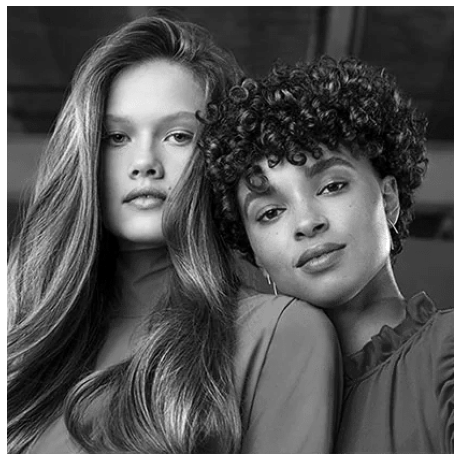

In [15]:
test_image = imread("test_image.png", as_gray=True)
plt.rcParams["figure.figsize"] = (8,12)
plt.imshow(test_image, cmap='gray')
plt.axis('off');

Confusion matrix


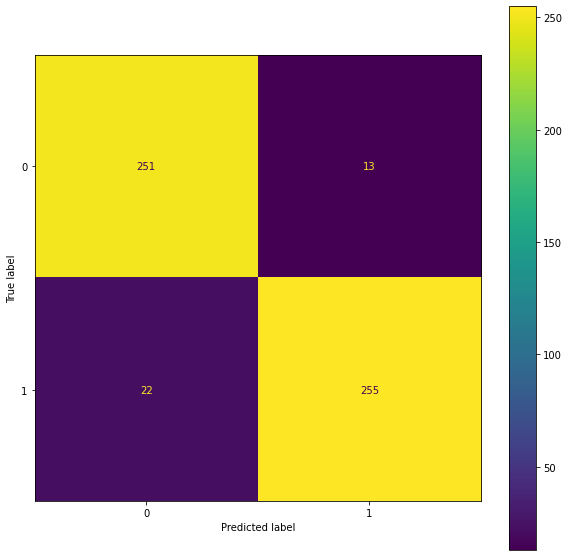

              precision    recall  f1-score   support

           0       0.92      0.95      0.93       264
           1       0.95      0.92      0.94       277

    accuracy                           0.94       541
   macro avg       0.94      0.94      0.94       541
weighted avg       0.94      0.94      0.94       541



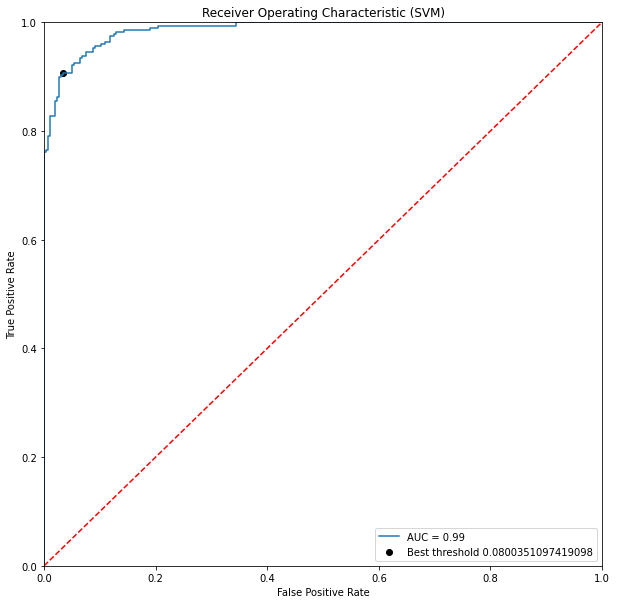

In [16]:
svm = SVC(C=2.231111111111111, gamma=0.01, kernel='rbf')
svm.fit(X_train_pca, y_train)

# Confusion matrix
print("Confusion matrix")
svc_pred = (svm.predict(X_test_pca))
plt.rcParams["figure.figsize"] = (10,10)
ConfusionMatrixDisplay.from_predictions(y_test, svc_pred)
plt.show()

# Classification report
print(classification_report(y_test, svc_pred))

# ROC en AUC
# ROC and AUC
svm_preds = svm.decision_function(X_test_pca)
svm_fpr, svm_tpr, svm_threshold = roc_curve(y_test, svm_preds)
svm_roc_auc = auc(svm_fpr, svm_tpr)
svm_gmeans = np.sqrt(svm_tpr * (1-svm_fpr))
svm_ix = np.argmax(svm_gmeans)

plt.title(f'Receiver Operating Characteristic (SVM)')
plt.plot(svm_fpr, svm_tpr, label = f'AUC = {svm_roc_auc:.2f}')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.scatter(svm_fpr[svm_ix], svm_tpr[svm_ix], marker='o', color='black', label=f'Best threshold {svm_threshold[svm_ix]}')
plt.legend(loc = 'lower right')
plt.show()

In [17]:
pos_patches = sliding_window(test_image)
pos_patches.head()

i    j  Ni  Nj                                              patch label
0   50  150  15  15  [[0.4302969235294118, 0.4322126529411765, 0.43...   [1]
1   75   75  15  15  [[0.4642384843137255, 0.46026866862745097, 0.4...   [1]
2  100   50  15  15  [[0.5431201803921569, 0.5291608549019609, 0.51...   [1]
3  100   75  15  15  [[0.6939244774509804, 0.7275290598039215, 0.76...   [1]
4  125   75  15  15  [[0.5006535921568628, 0.5389352470588235, 0.57...   [1]

In [18]:
print(f'Het aantal weerhouden windows: \t{pos_patches.shape[0]}')

Het aantal weerhouden windows: 	516


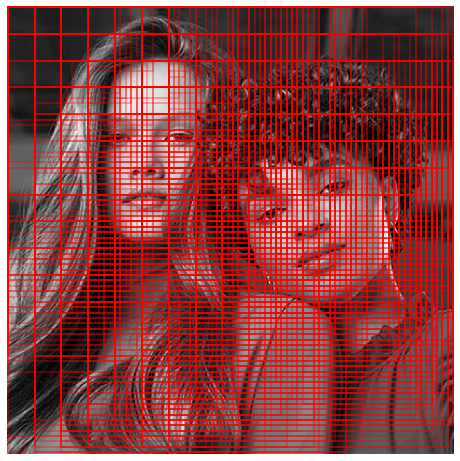

In [19]:
fig, ax = plt.subplots(figsize=(8,12))
ax.imshow(test_image, cmap='gray')
ax.axis('off')

boxes = []
for index, row in pos_patches.iterrows():
    ax.add_patch(plt.Rectangle((row['j'], row['i']), row['Nj'], row['Ni'], edgecolor='red', alpha=0.3, lw=2, facecolor='none'))
    box = (row['j'], row['i'], row['j']+row['Nj'], row['i']+row['Ni'])
    boxes.append(box)
boxes = np.array(boxes)

Er zijn 516 windows weerhouden. Deze werden hierboven getekend bovenop de afbeelding. Een groot deel van de boxes overlappen. De non_max_suppression_fast functie wordt gebruikt om de overlappende boxes weg te werken.

In [20]:
len(boxes)

516

In [21]:
new_boxes = non_max_suppression_fast(boxes, 0.3)

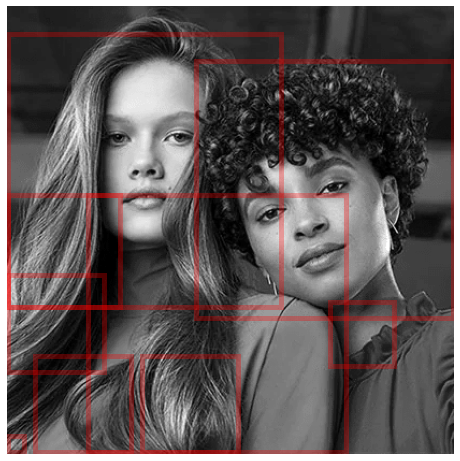

In [22]:
fig, ax = plt.subplots(figsize=(8,12))
ax.imshow(test_image, cmap='gray')
ax.axis('off')

for (x1, y1, x2, y2) in new_boxes:
    ax.add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, edgecolor='red', alpha=0.3, lw=5, facecolor='none'))

Hierbocen worden de uiteindelijk boxes getoond bovenop de afbeelding. De meeste boxes hebben effectief betrekking op de aanwezige gezichten, maar er zijn echter ook boxes die niets met gezichten te maken hebben. Het algoritme is daarom niet volledig geschikt voor face detection.